# Import dependencies

In [1]:
import numpy as np
import matplotlib as mpl
from dolfinx import fem, mesh
from dataclasses import dataclass
from mpi4py import MPI
from src.solveStateEquation import getSourceTerm, solveStateEquation, buildControlFunction
from src.visualization import plot_array, printIterationInfo
from src.ExtremalPoints import ExtremalPoint
from src.HesseMatrix import HesseMatrix
from src.osqp import computeOSQPStep
from src.iterationHelpers import pruneActiveSet, calculateDiscreteGradient, integrateVectorFunction, getIdxMax
from src.helpers import buildIterationFunction, computeObjective

# Set parameters

In [2]:
@dataclass
class Parameters:
    T = 1
    dt = 0.005
    x1 = (0.5, 0.5)
    x2 = (-0.5, -0.5)
    area = 4
    d = 2
    mollify_const = 0.2
    newton_c = 100
    eta = 0.01
    alpha = 1e-4
    beta = 1e-4
    waveSpeed = 1
    randomFactor = 0.00
    maxIterations = 50
    pruneThreshold = 1e-2
    yd = []
    standardInnerProducts = None
    msh = mesh.create_rectangle(
        comm=MPI.COMM_WORLD,
        points=((-1., -1.), (1.0, 1.0)),
        n=(64, 64),
        cell_type=mesh.CellType.triangle,
    )
    V = fem.functionspace(msh, ("Lagrange", 1))
    
params = Parameters()

# Setup problem

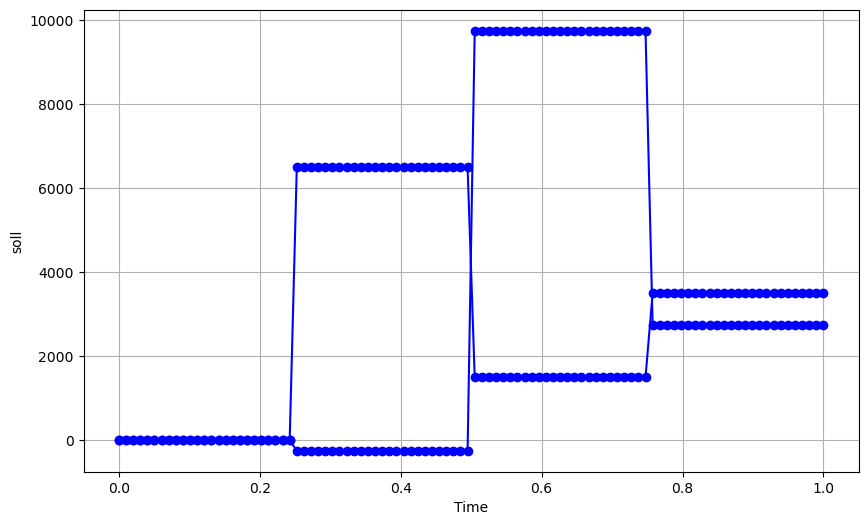

In [3]:
s1 = lambda t : 0.05 if t <= 0.25 else (0.65 if t <= 0.5 else (0.15 if t <= 0.75 else 0.35)) / params.alpha
s2 = lambda t : 0.775 if t <= 0.25 else (-0.025 if t <= 0.5 else (0.975 if t <= 0.75 else 0.275)) / params.alpha
g1 = getSourceTerm(params.x1, params)
g2 = getSourceTerm(params.x2, params)
control = buildControlFunction([g1, g2], [s1, s2], params)
K_u = solveStateEquation(control, params)
grid_size = K_u[0].x.array.shape
raw_matrices = [K_u_t.x.array for K_u_t in K_u]
norms = [np.linalg.norm(matrix, ord=2) for matrix in raw_matrices]
scale = params.randomFactor * np.mean(norms) / grid_size[0] * params.area
np.random.seed(42)
yd = [fem.Function(params.V) for _ in K_u]
for idx in range(len(yd)):
    yd[idx].x.array[:] = K_u[idx].x.array + np.random.normal(loc=0.0, scale=scale, size=grid_size)
params.yd = yd

discretInterval = np.linspace(0, params.T, int(params.T/params.dt))
array = np.ndarray((int(params.T/params.dt), 2))
array[:, 0] = np.array([s1(t) for t in discretInterval])
array[:, 1] = np.array([s2(t) for t in discretInterval])
plot_array(array, params.T, label='soll')

# Minimization algorithm

Objective upper bound:  27956.511477114145
weights:  [] slope:  [ 4492.80544695 12999.61234528] y_shift [ 1210.33780068 -2327.96859469]
Objective:  1311.135711971552
0 : Active set:
slope:  [ 4492.80544695 12999.61234528] y_shift [ 1210.33780068 -2327.96859469]
0 : Hesse condition: 110.64359740127988


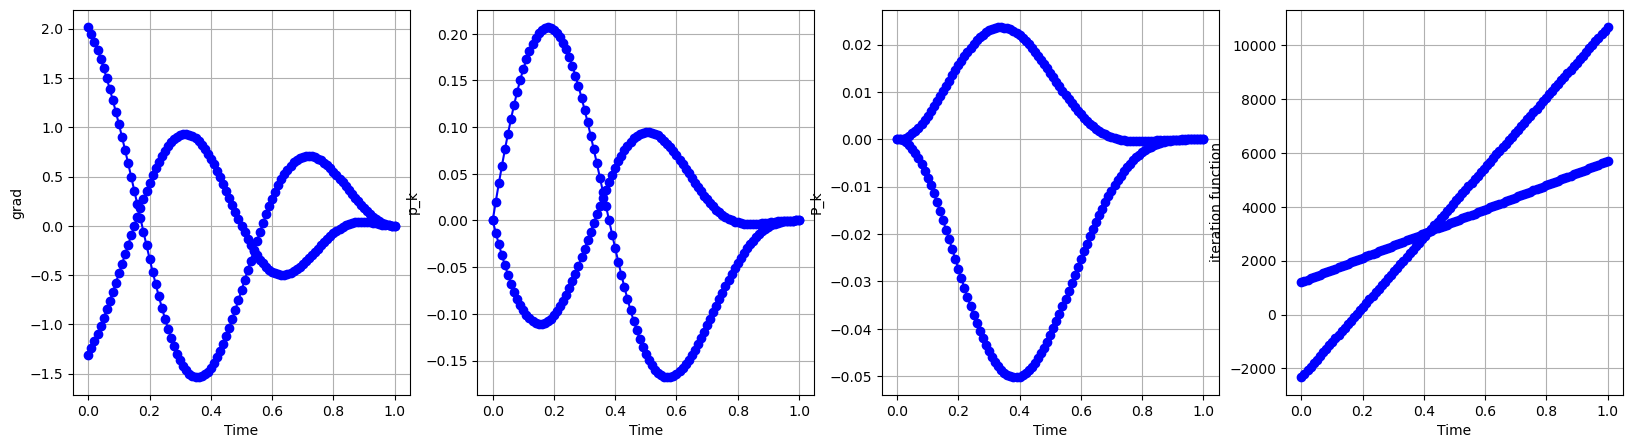

|p_max|/alpha:  2335.296126115643 , |P_max|/beta:  552.0627969887743
x_S:  0.17 x_K:  0.38 
New point: sigma= [ 0.88294431 -0.46947774] x_0 = 0.17 , type = 0
weights:  [0.22968744] slope:  [ 585.475182   2039.06838452] y_shift [ 944.67726993 1652.21104567]
Objective:  5217.375536620217
1 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.22968743618470128 	id: 140534292972704
slope:  [ 585.475182   2039.06838452] y_shift [ 944.67726993 1652.21104567]
1 : Hesse condition: 21220311902.27519


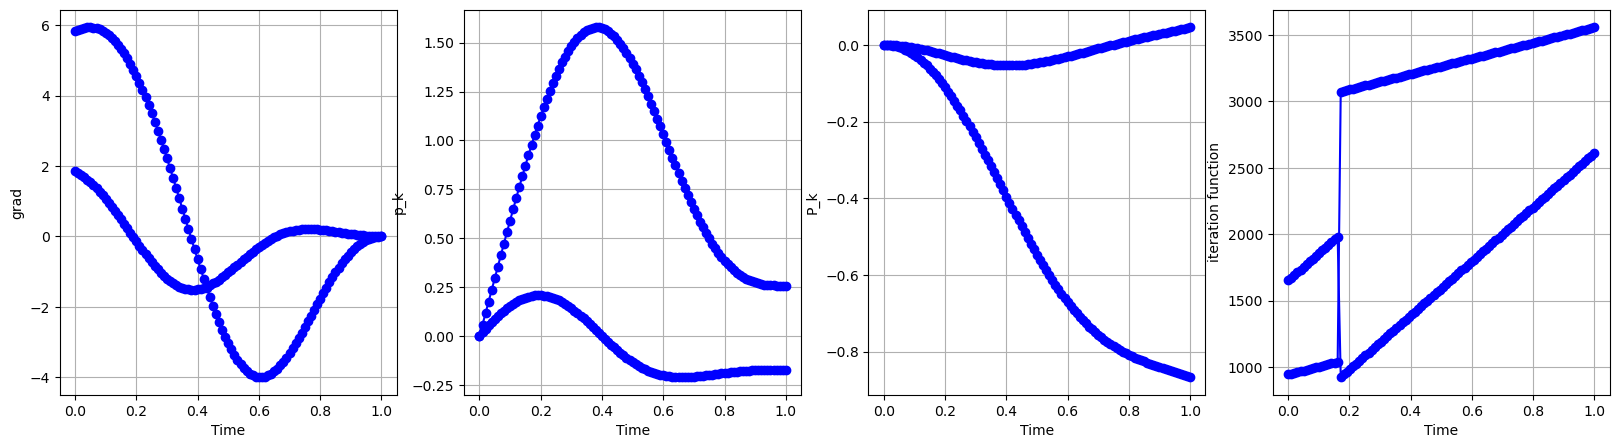

|p_max|/alpha:  15790.27461020996 , |P_max|/beta:  8653.623904303866
x_S:  0.38 x_K:  0.99 
New point: sigma= [0.0199031  0.99980191] x_0 = 0.38 , type = 0
weights:  [0.40137333 0.78242965] slope:  [ 34.93134993 141.98416526] y_shift [138.22048119 194.17291399]
Objective:  462.5587452096711
2 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.4013733275401189 	id: 140534292972704
	 1 sigma= [0.0199031  0.99980191] ,	x_0 = 0.38 ,	type = 0 	weight: 0.7824296482708394 	id: 140534292571888
slope:  [ 34.93134993 141.98416526] y_shift [138.22048119 194.17291399]
2 : Hesse condition: 190443479428.04407


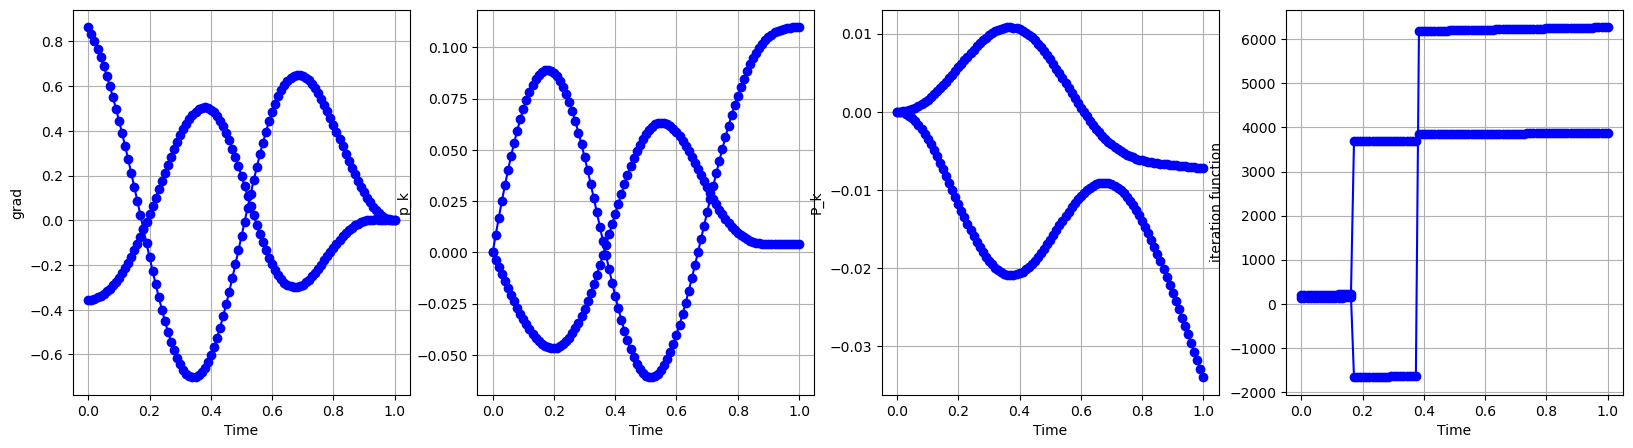

|p_max|/alpha:  1098.2020531747264 , |P_max|/beta:  336.66177856518993
x_S:  0.99 x_K:  0.99 
New point: sigma= [0.99930285 0.03733392] x_0 = 0.99 , type = 0
weights:  [4.01373328e-01 7.82429648e-01 6.31358163e-08] slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
Objective:  462.5587452870167
3 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.4013733276424912 	id: 140534292972704
	 1 sigma= [0.0199031  0.99980191] ,	x_0 = 0.38 ,	type = 0 	weight: 0.7824296482113187 	id: 140534292571888
slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
3 : Hesse condition: 190443479428.04407


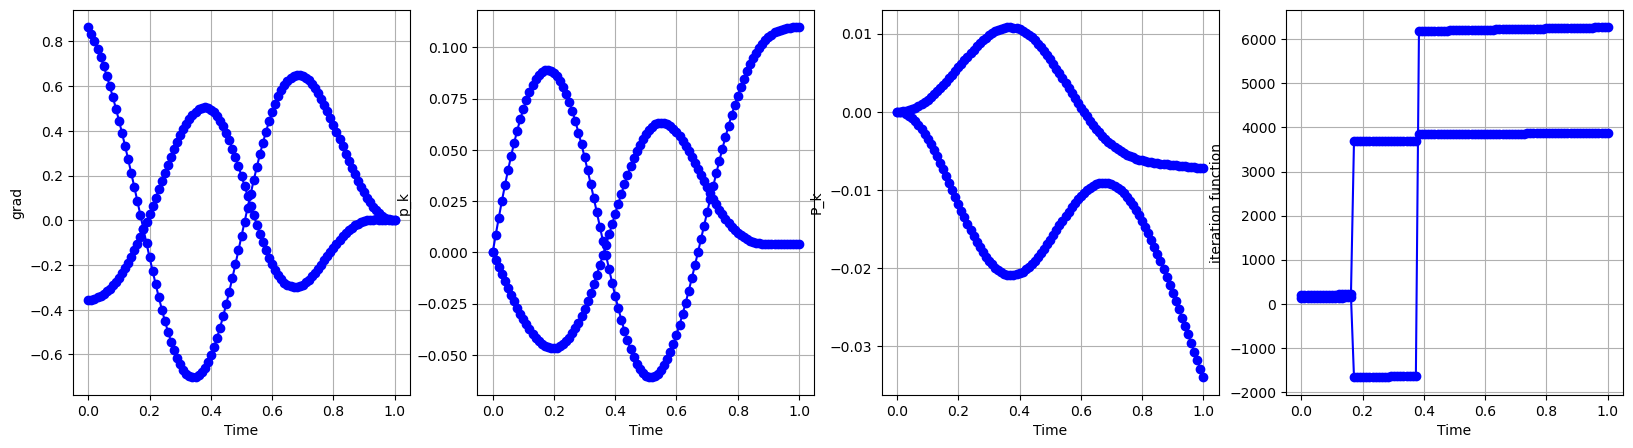

|p_max|/alpha:  1098.2020489732718 , |P_max|/beta:  336.66177395866737
x_S:  0.99 x_K:  0.99 
New point: sigma= [0.99930285 0.03733392] x_0 = 0.99 , type = 0
weights:  [4.01373328e-01 7.82429648e-01 6.31358143e-08] slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
Objective:  462.5587452870168
4 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.4013733276424911 	id: 140534292972704
	 1 sigma= [0.0199031  0.99980191] ,	x_0 = 0.38 ,	type = 0 	weight: 0.7824296482113187 	id: 140534292571888
slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
4 : Hesse condition: 190443479428.04407


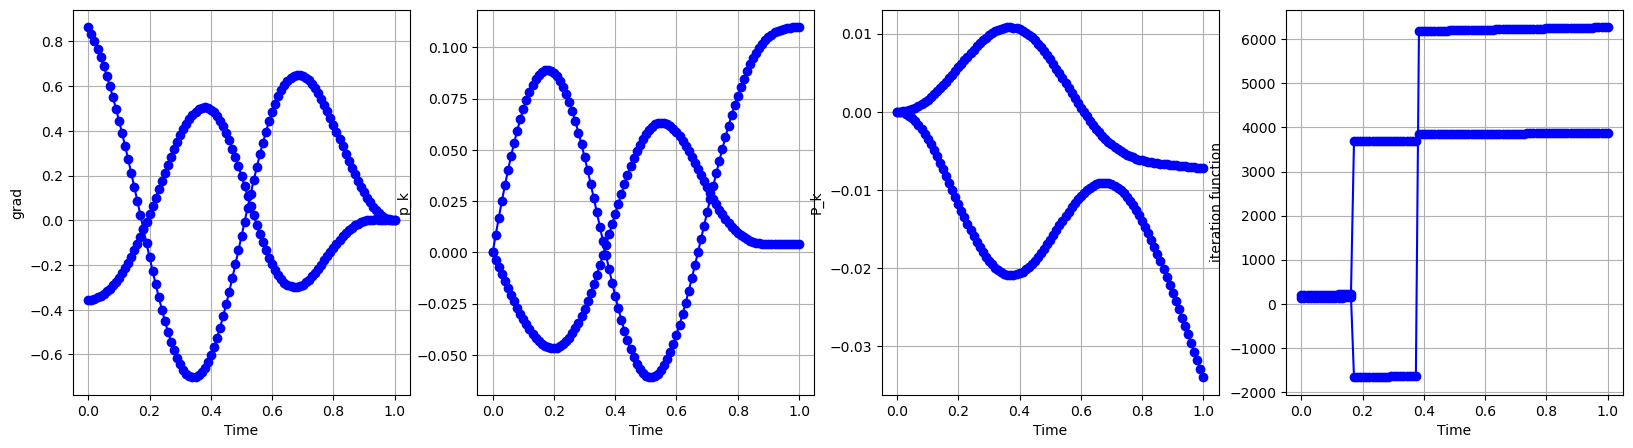

|p_max|/alpha:  1098.2020489733445 , |P_max|/beta:  336.66177395871404
x_S:  0.99 x_K:  0.99 
New point: sigma= [0.99930285 0.03733392] x_0 = 0.99 , type = 0
weights:  [4.01373328e-01 7.82429648e-01 6.31358143e-08] slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
Objective:  462.5587452870168
5 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.4013733276424911 	id: 140534292972704
	 1 sigma= [0.0199031  0.99980191] ,	x_0 = 0.38 ,	type = 0 	weight: 0.7824296482113187 	id: 140534292571888
slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
5 : Hesse condition: 190443479428.04407


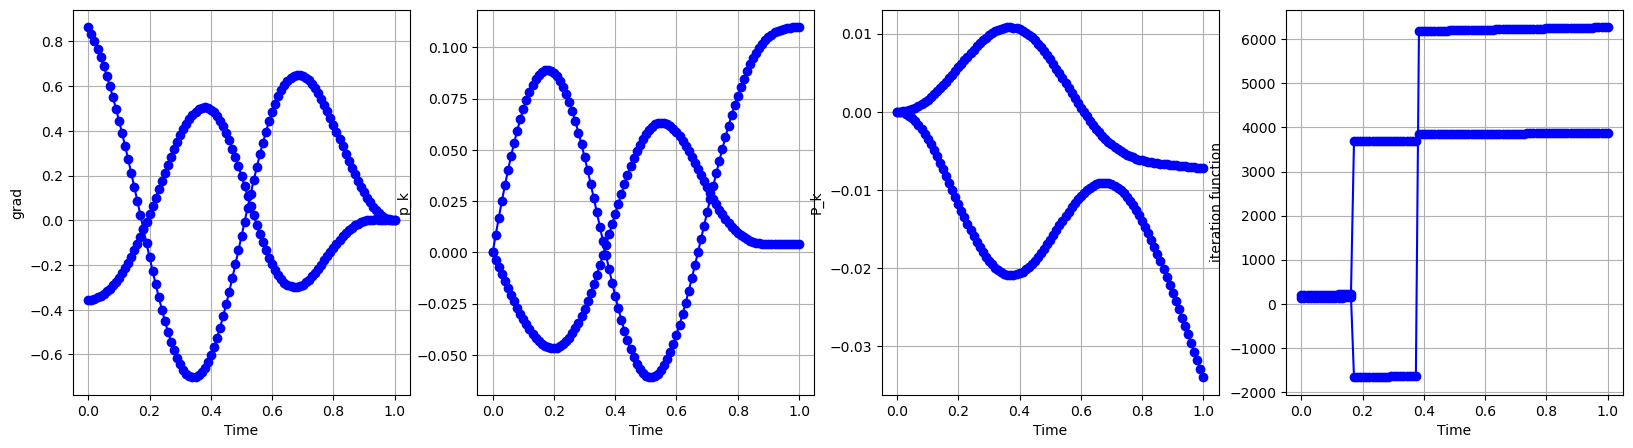

|p_max|/alpha:  1098.2020489733445 , |P_max|/beta:  336.66177395871404
x_S:  0.99 x_K:  0.99 
New point: sigma= [0.99930285 0.03733392] x_0 = 0.99 , type = 0
weights:  [4.01373328e-01 7.82429648e-01 6.31358143e-08] slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
Objective:  462.5587452870168
6 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.4013733276424911 	id: 140534292972704
	 1 sigma= [0.0199031  0.99980191] ,	x_0 = 0.38 ,	type = 0 	weight: 0.7824296482113187 	id: 140534292571888
slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
6 : Hesse condition: 190443479428.04407


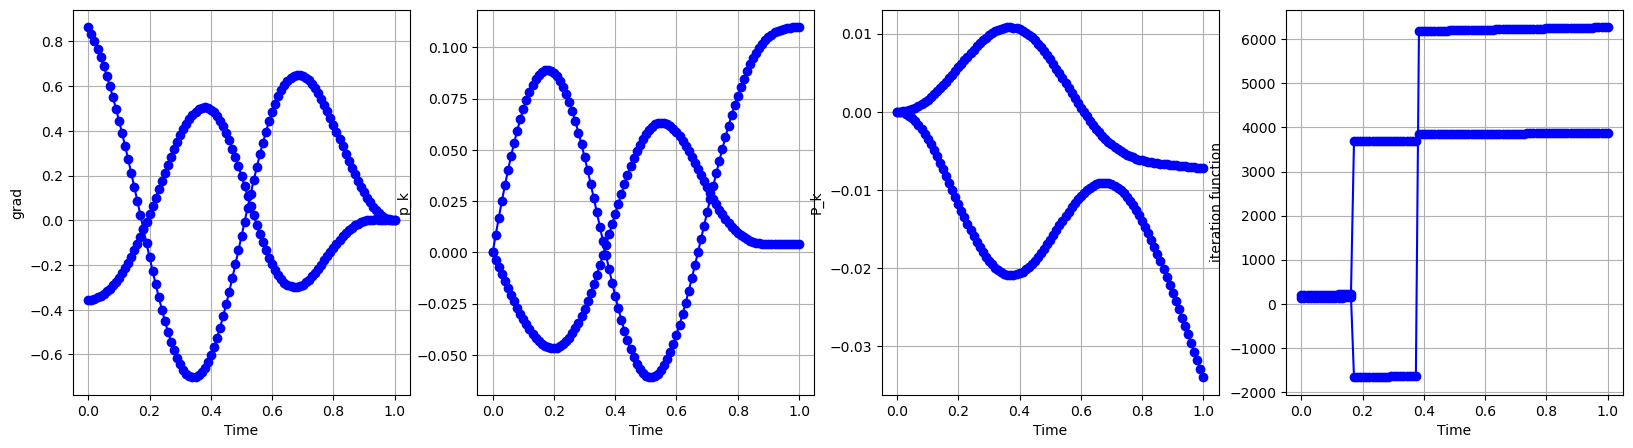

|p_max|/alpha:  1098.2020489733445 , |P_max|/beta:  336.66177395871404
x_S:  0.99 x_K:  0.99 
New point: sigma= [0.99930285 0.03733392] x_0 = 0.99 , type = 0
weights:  [4.01373328e-01 7.82429648e-01 6.31358143e-08] slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
Objective:  462.5587452870168
7 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.4013733276424911 	id: 140534292972704
	 1 sigma= [0.0199031  0.99980191] ,	x_0 = 0.38 ,	type = 0 	weight: 0.7824296482113187 	id: 140534292571888
slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
7 : Hesse condition: 190443479428.04407


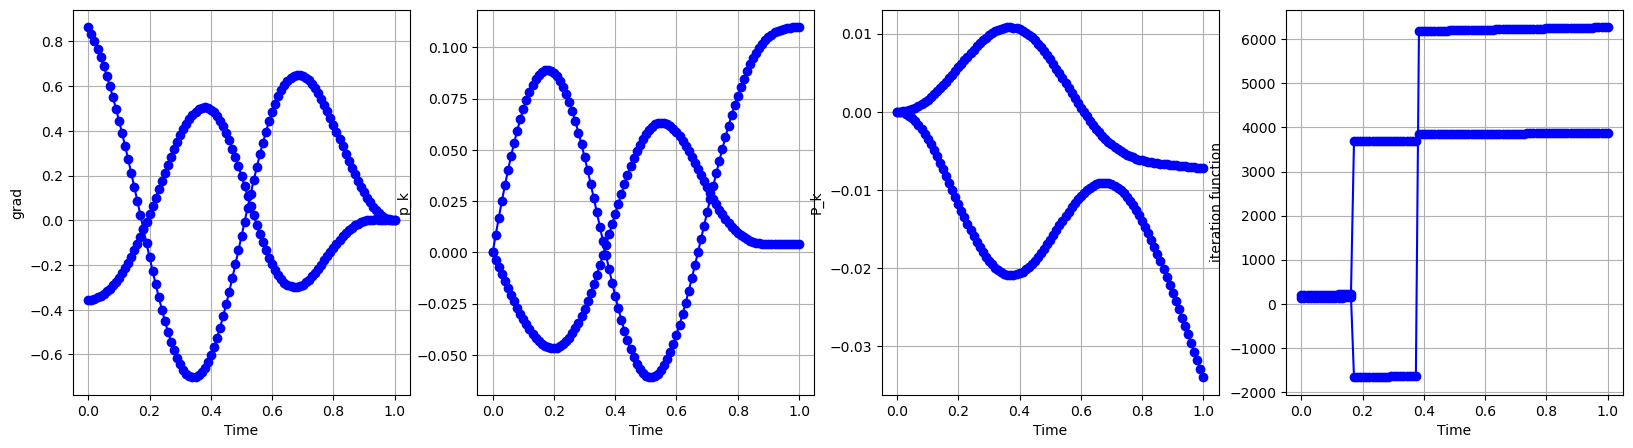

|p_max|/alpha:  1098.2020489733445 , |P_max|/beta:  336.66177395871404
x_S:  0.99 x_K:  0.99 
New point: sigma= [0.99930285 0.03733392] x_0 = 0.99 , type = 0
weights:  [4.01373328e-01 7.82429648e-01 6.31358143e-08] slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
Objective:  462.5587452870168
8 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.4013733276424911 	id: 140534292972704
	 1 sigma= [0.0199031  0.99980191] ,	x_0 = 0.38 ,	type = 0 	weight: 0.7824296482113187 	id: 140534292571888
slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
8 : Hesse condition: 190443479428.04407


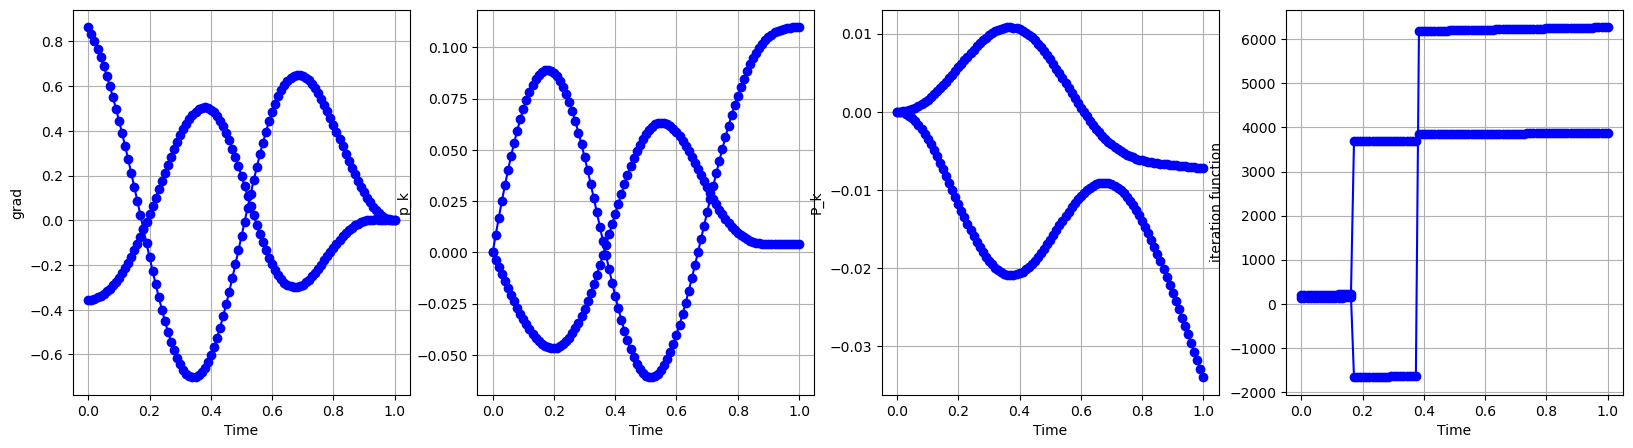

|p_max|/alpha:  1098.2020489733445 , |P_max|/beta:  336.66177395871404
x_S:  0.99 x_K:  0.99 
New point: sigma= [0.99930285 0.03733392] x_0 = 0.99 , type = 0
weights:  [4.01373328e-01 7.82429648e-01 6.31358143e-08] slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
Objective:  462.5587452870168
9 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.4013733276424911 	id: 140534292972704
	 1 sigma= [0.0199031  0.99980191] ,	x_0 = 0.38 ,	type = 0 	weight: 0.7824296482113187 	id: 140534292571888
slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
9 : Hesse condition: 190443479428.04407


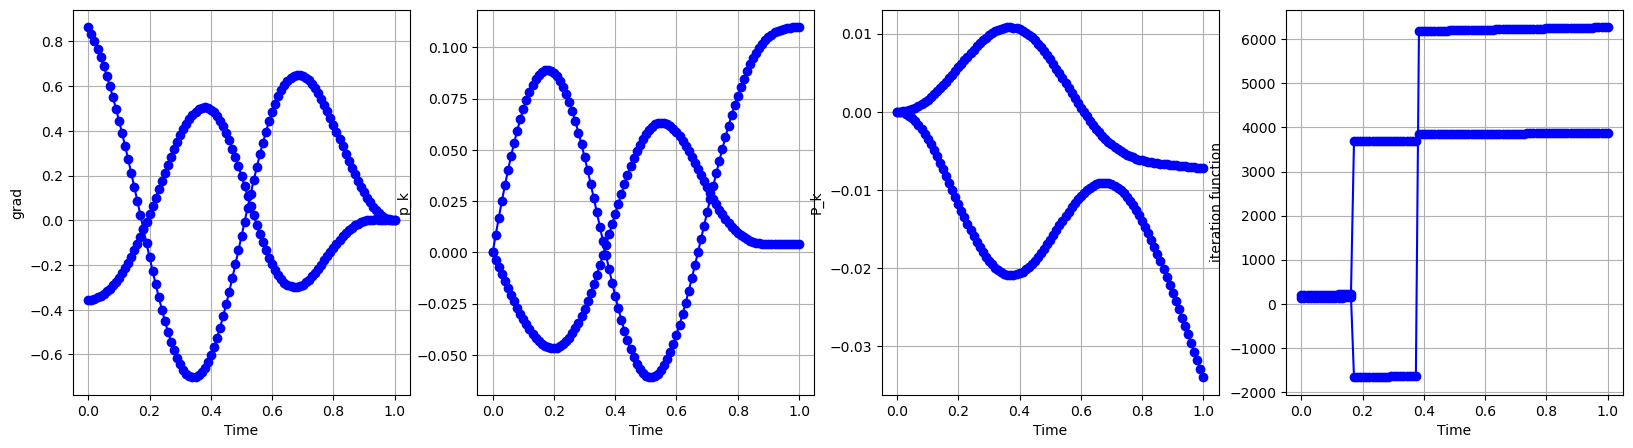

|p_max|/alpha:  1098.2020489733445 , |P_max|/beta:  336.66177395871404
x_S:  0.99 x_K:  0.99 
New point: sigma= [0.99930285 0.03733392] x_0 = 0.99 , type = 0
weights:  [4.01373328e-01 7.82429648e-01 6.31358143e-08] slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
Objective:  462.5587452870168
10 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.4013733276424911 	id: 140534292972704
	 1 sigma= [0.0199031  0.99980191] ,	x_0 = 0.38 ,	type = 0 	weight: 0.7824296482113187 	id: 140534292571888
slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
10 : Hesse condition: 190443479428.04407


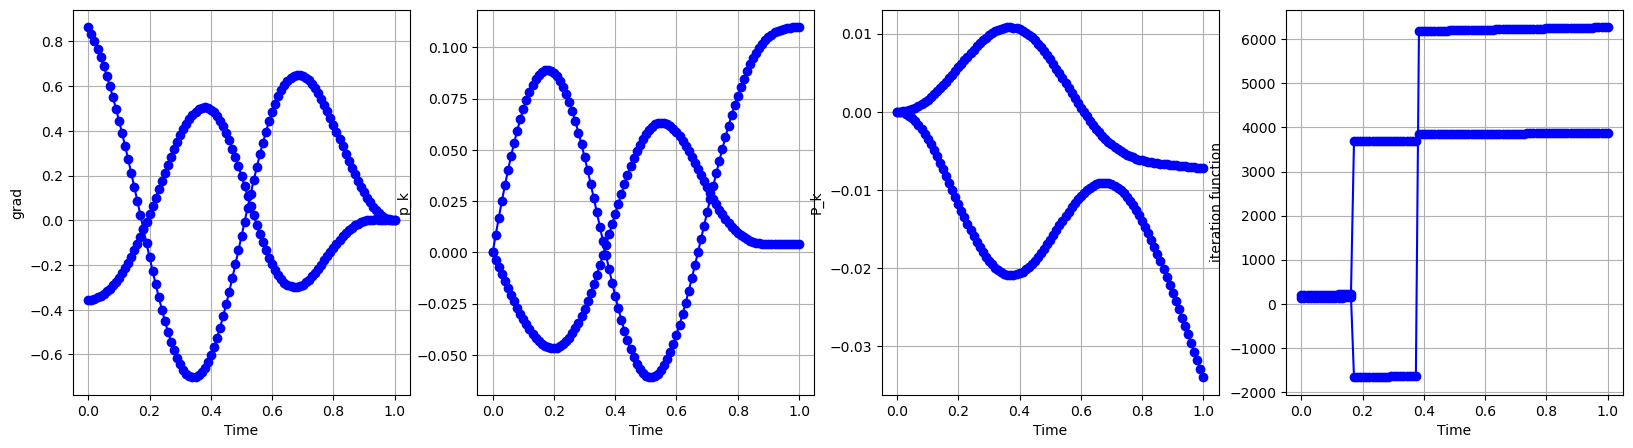

|p_max|/alpha:  1098.2020489733445 , |P_max|/beta:  336.66177395871404
x_S:  0.99 x_K:  0.99 
New point: sigma= [0.99930285 0.03733392] x_0 = 0.99 , type = 0
weights:  [4.01373328e-01 7.82429648e-01 6.31358143e-08] slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
Objective:  462.5587452870168
11 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.4013733276424911 	id: 140534292972704
	 1 sigma= [0.0199031  0.99980191] ,	x_0 = 0.38 ,	type = 0 	weight: 0.7824296482113187 	id: 140534292571888
slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
11 : Hesse condition: 190443479428.04407


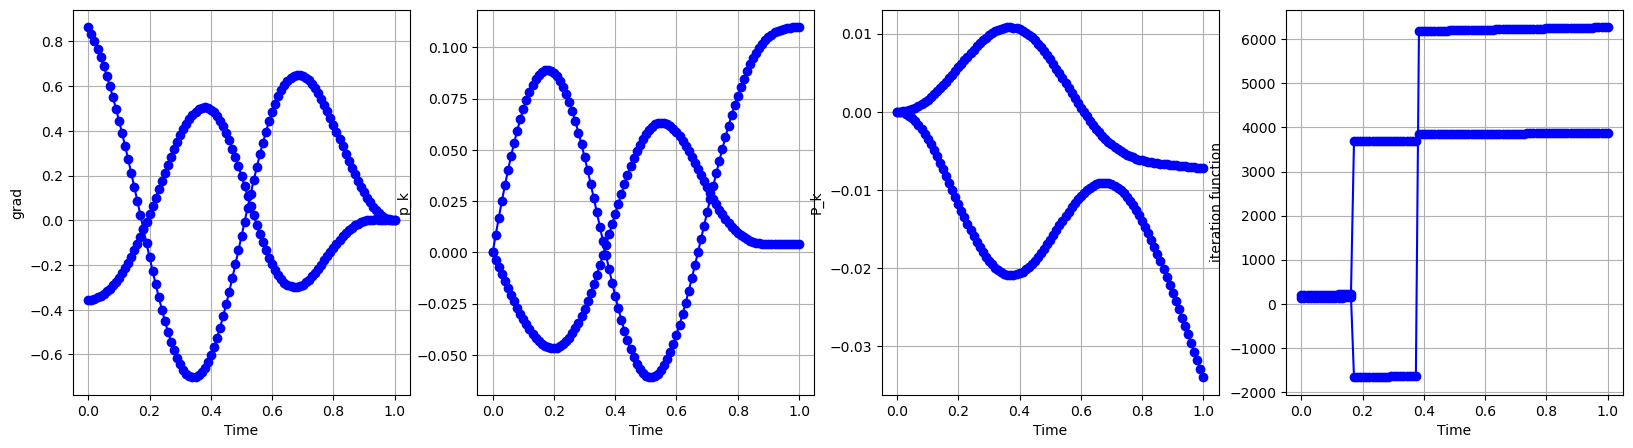

|p_max|/alpha:  1098.2020489733445 , |P_max|/beta:  336.66177395871404
x_S:  0.99 x_K:  0.99 
New point: sigma= [0.99930285 0.03733392] x_0 = 0.99 , type = 0
weights:  [4.01373328e-01 7.82429648e-01 6.31358143e-08] slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
Objective:  462.5587452870168
12 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.4013733276424911 	id: 140534292972704
	 1 sigma= [0.0199031  0.99980191] ,	x_0 = 0.38 ,	type = 0 	weight: 0.7824296482113187 	id: 140534292571888
slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
12 : Hesse condition: 190443479428.04407


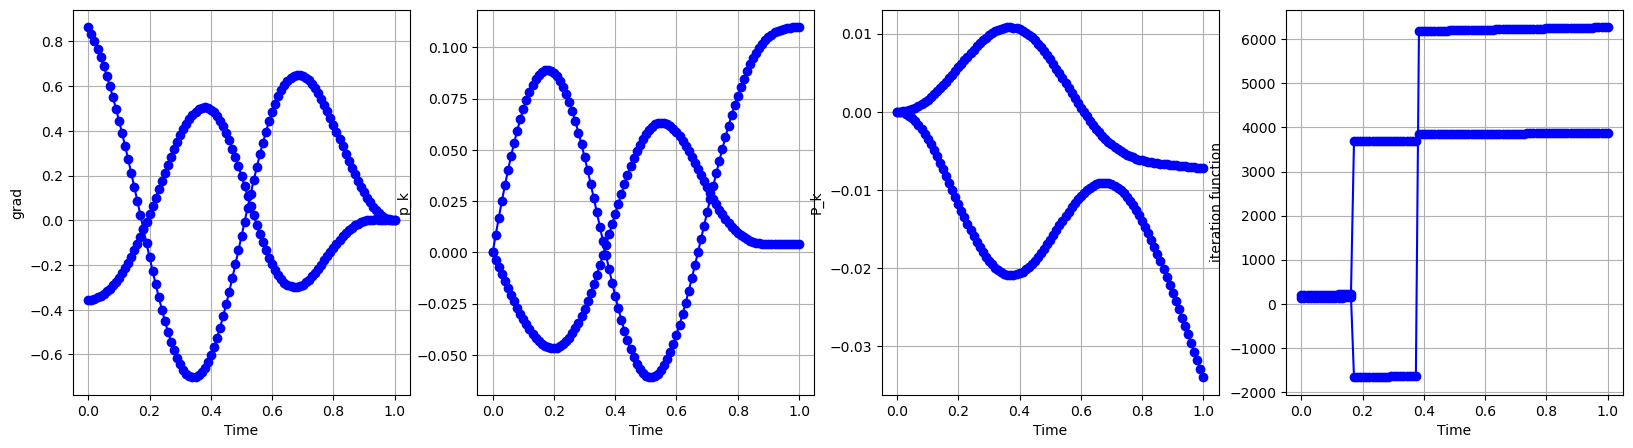

|p_max|/alpha:  1098.2020489733445 , |P_max|/beta:  336.66177395871404
x_S:  0.99 x_K:  0.99 
New point: sigma= [0.99930285 0.03733392] x_0 = 0.99 , type = 0
weights:  [4.01373328e-01 7.82429648e-01 6.31358143e-08] slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
Objective:  462.5587452870168
13 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.4013733276424911 	id: 140534292972704
	 1 sigma= [0.0199031  0.99980191] ,	x_0 = 0.38 ,	type = 0 	weight: 0.7824296482113187 	id: 140534292571888
slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
13 : Hesse condition: 190443479428.04407


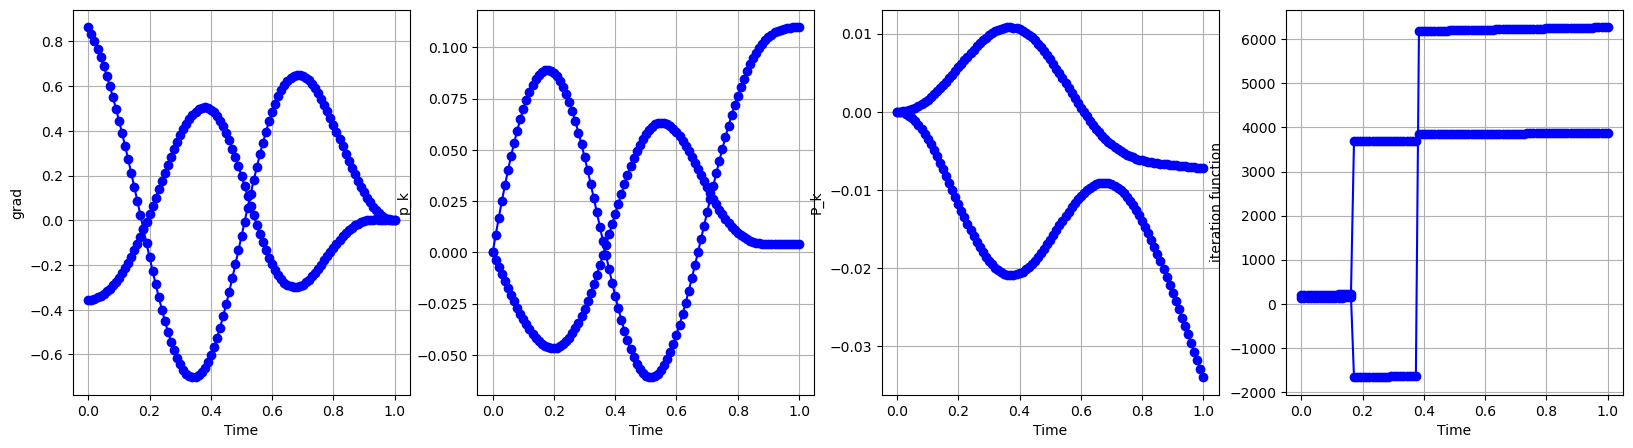

|p_max|/alpha:  1098.2020489733445 , |P_max|/beta:  336.66177395871404
x_S:  0.99 x_K:  0.99 
New point: sigma= [0.99930285 0.03733392] x_0 = 0.99 , type = 0
weights:  [4.01373328e-01 7.82429648e-01 6.31358143e-08] slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
Objective:  462.5587452870168
14 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.4013733276424911 	id: 140534292972704
	 1 sigma= [0.0199031  0.99980191] ,	x_0 = 0.38 ,	type = 0 	weight: 0.7824296482113187 	id: 140534292571888
slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
14 : Hesse condition: 190443479428.04407


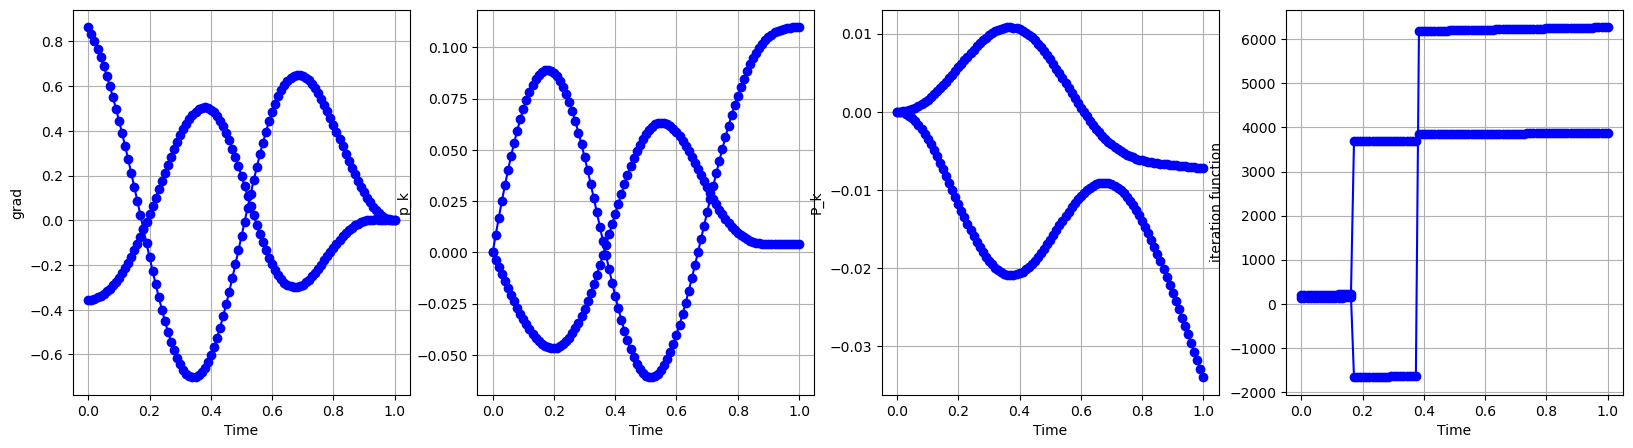

|p_max|/alpha:  1098.2020489733445 , |P_max|/beta:  336.66177395871404
x_S:  0.99 x_K:  0.99 
New point: sigma= [0.99930285 0.03733392] x_0 = 0.99 , type = 0
weights:  [4.01373328e-01 7.82429648e-01 6.31358143e-08] slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
Objective:  462.5587452870168
15 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.4013733276424911 	id: 140534292972704
	 1 sigma= [0.0199031  0.99980191] ,	x_0 = 0.38 ,	type = 0 	weight: 0.7824296482113187 	id: 140534292571888
slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
15 : Hesse condition: 190443479428.04407


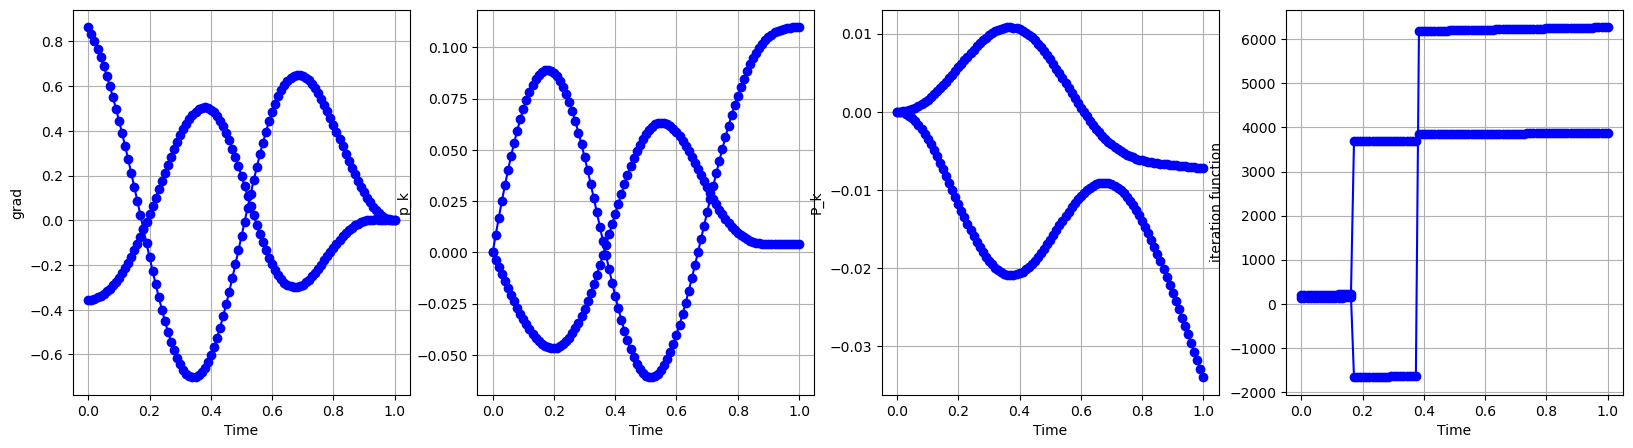

|p_max|/alpha:  1098.2020489733445 , |P_max|/beta:  336.66177395871404
x_S:  0.99 x_K:  0.99 
New point: sigma= [0.99930285 0.03733392] x_0 = 0.99 , type = 0
weights:  [4.01373328e-01 7.82429648e-01 6.31358143e-08] slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
Objective:  462.5587452870168
16 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.4013733276424911 	id: 140534292972704
	 1 sigma= [0.0199031  0.99980191] ,	x_0 = 0.38 ,	type = 0 	weight: 0.7824296482113187 	id: 140534292571888
slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
16 : Hesse condition: 190443479428.04407


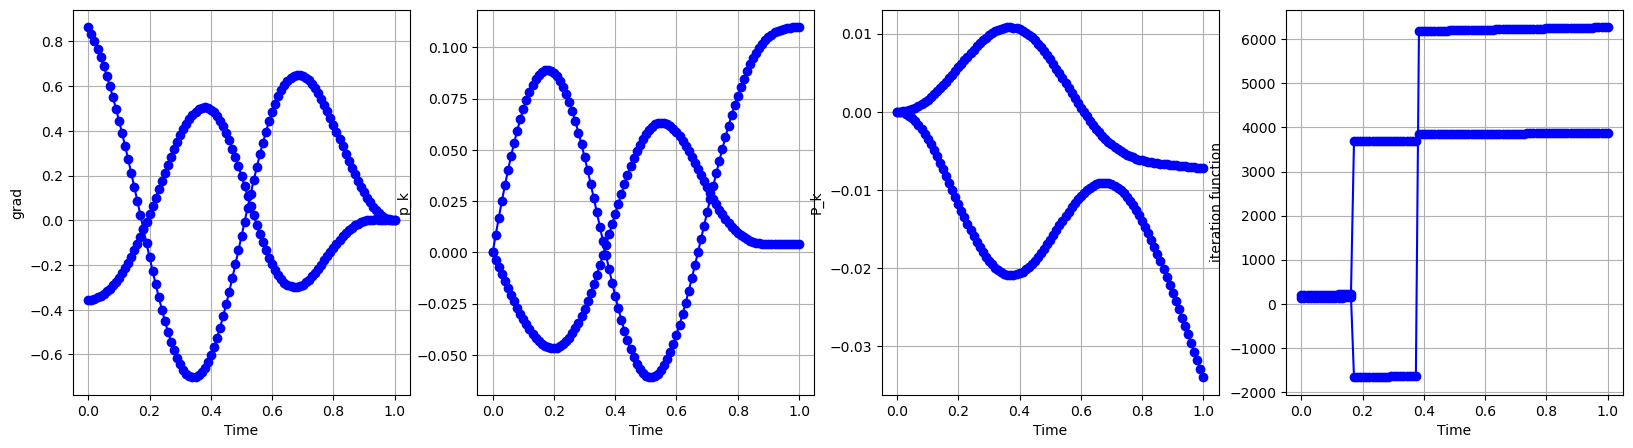

|p_max|/alpha:  1098.2020489733445 , |P_max|/beta:  336.66177395871404
x_S:  0.99 x_K:  0.99 
New point: sigma= [0.99930285 0.03733392] x_0 = 0.99 , type = 0
weights:  [4.01373328e-01 7.82429648e-01 6.31358143e-08] slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
Objective:  462.5587452870168
17 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.4013733276424911 	id: 140534292972704
	 1 sigma= [0.0199031  0.99980191] ,	x_0 = 0.38 ,	type = 0 	weight: 0.7824296482113187 	id: 140534292571888
slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
17 : Hesse condition: 190443479428.04407


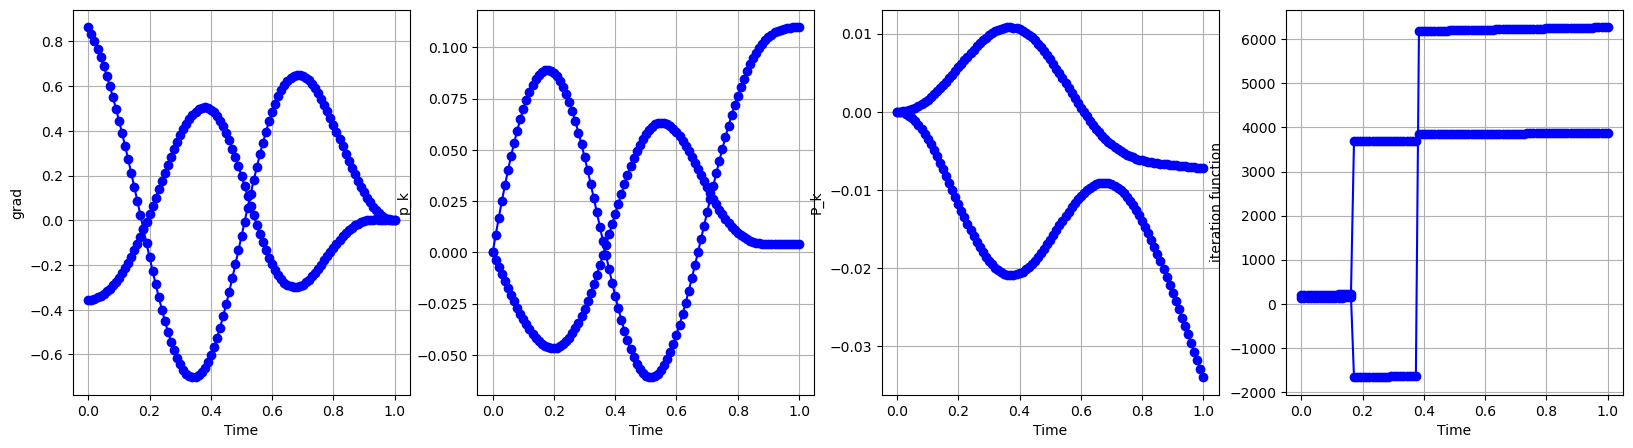

|p_max|/alpha:  1098.2020489733445 , |P_max|/beta:  336.66177395871404
x_S:  0.99 x_K:  0.99 
New point: sigma= [0.99930285 0.03733392] x_0 = 0.99 , type = 0
weights:  [4.01373328e-01 7.82429648e-01 6.31358143e-08] slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
Objective:  462.5587452870168
18 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.4013733276424911 	id: 140534292972704
	 1 sigma= [0.0199031  0.99980191] ,	x_0 = 0.38 ,	type = 0 	weight: 0.7824296482113187 	id: 140534292571888
slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
18 : Hesse condition: 190443479428.04407


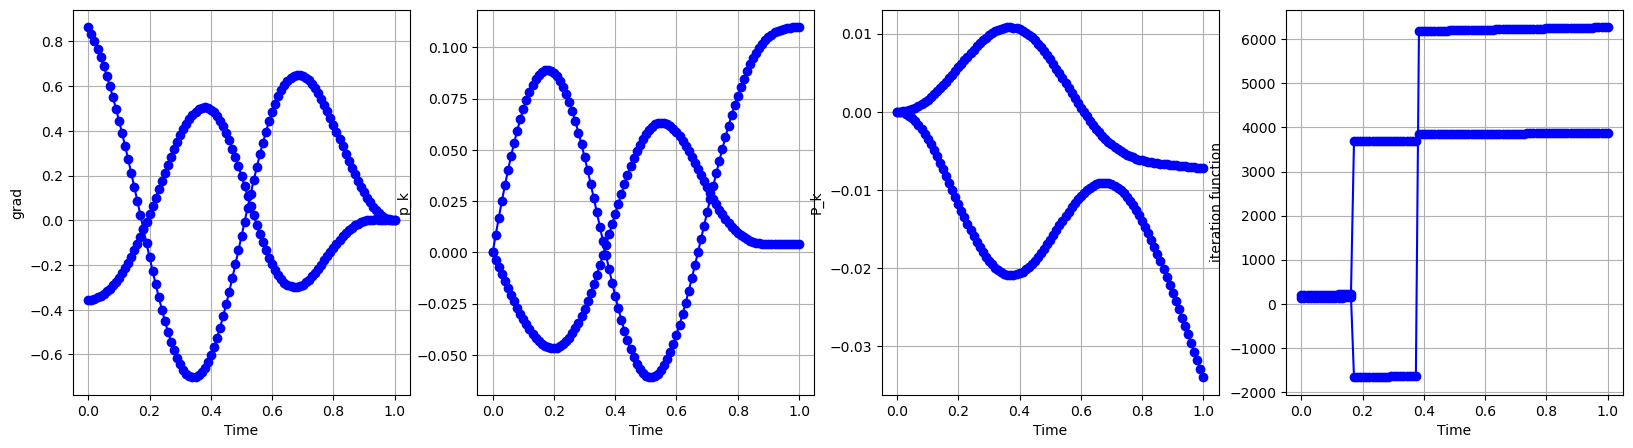

|p_max|/alpha:  1098.2020489733445 , |P_max|/beta:  336.66177395871404
x_S:  0.99 x_K:  0.99 
New point: sigma= [0.99930285 0.03733392] x_0 = 0.99 , type = 0
weights:  [4.01373328e-01 7.82429648e-01 6.31358143e-08] slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
Objective:  462.5587452870168
19 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.4013733276424911 	id: 140534292972704
	 1 sigma= [0.0199031  0.99980191] ,	x_0 = 0.38 ,	type = 0 	weight: 0.7824296482113187 	id: 140534292571888
slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
19 : Hesse condition: 190443479428.04407


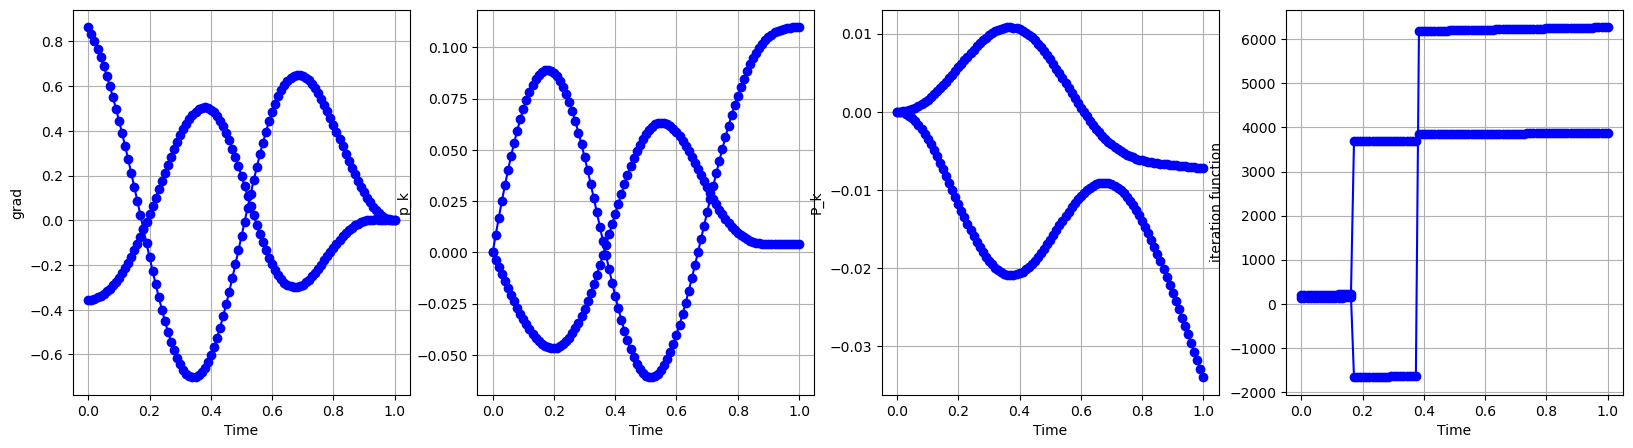

|p_max|/alpha:  1098.2020489733445 , |P_max|/beta:  336.66177395871404
x_S:  0.99 x_K:  0.99 
New point: sigma= [0.99930285 0.03733392] x_0 = 0.99 , type = 0
weights:  [4.01373328e-01 7.82429648e-01 6.31358143e-08] slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
Objective:  462.5587452870168
20 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.4013733276424911 	id: 140534292972704
	 1 sigma= [0.0199031  0.99980191] ,	x_0 = 0.38 ,	type = 0 	weight: 0.7824296482113187 	id: 140534292571888
slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
20 : Hesse condition: 190443479428.04407


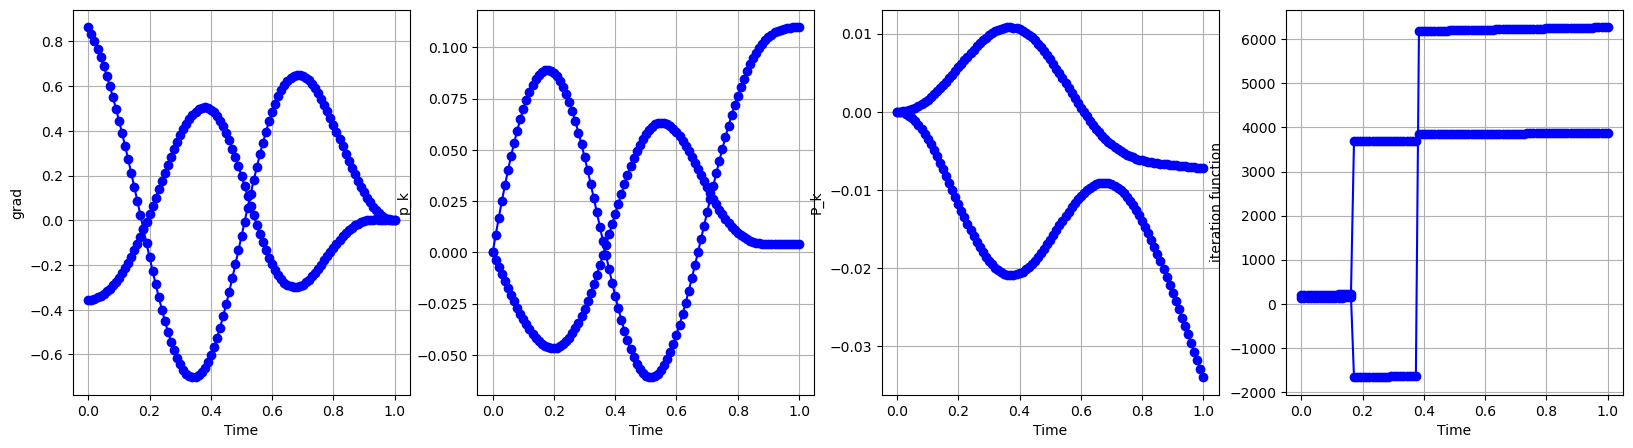

|p_max|/alpha:  1098.2020489733445 , |P_max|/beta:  336.66177395871404
x_S:  0.99 x_K:  0.99 
New point: sigma= [0.99930285 0.03733392] x_0 = 0.99 , type = 0
weights:  [4.01373328e-01 7.82429648e-01 6.31358143e-08] slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
Objective:  462.5587452870168
21 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.4013733276424911 	id: 140534292972704
	 1 sigma= [0.0199031  0.99980191] ,	x_0 = 0.38 ,	type = 0 	weight: 0.7824296482113187 	id: 140534292571888
slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
21 : Hesse condition: 190443479428.04407


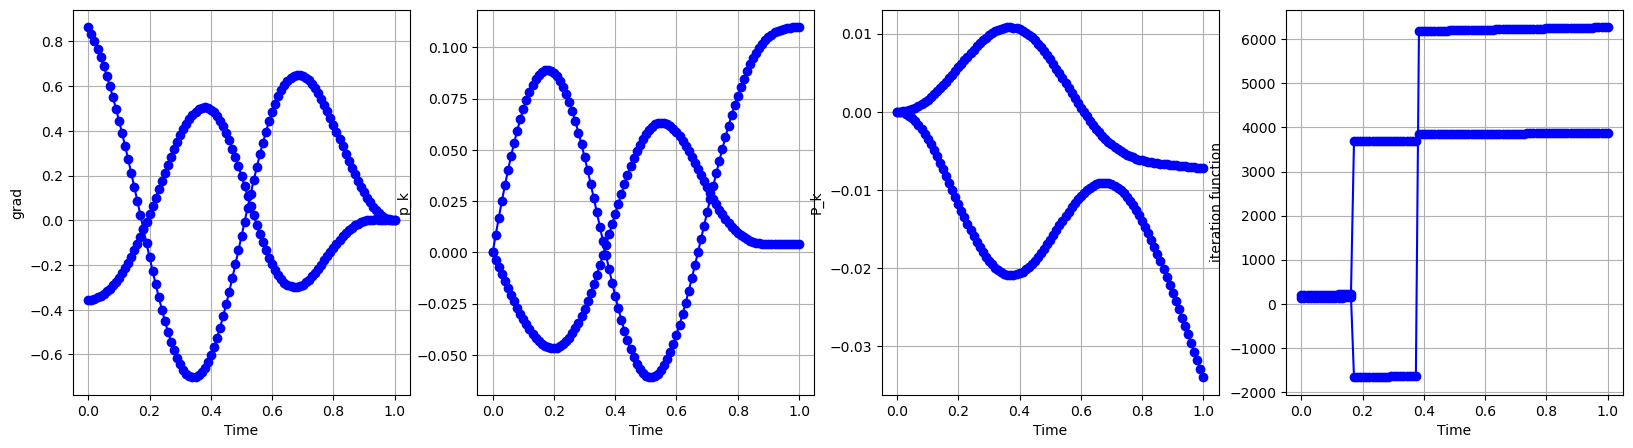

|p_max|/alpha:  1098.2020489733445 , |P_max|/beta:  336.66177395871404
x_S:  0.99 x_K:  0.99 
New point: sigma= [0.99930285 0.03733392] x_0 = 0.99 , type = 0
weights:  [4.01373328e-01 7.82429648e-01 6.31358143e-08] slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
Objective:  462.5587452870168
22 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.4013733276424911 	id: 140534292972704
	 1 sigma= [0.0199031  0.99980191] ,	x_0 = 0.38 ,	type = 0 	weight: 0.7824296482113187 	id: 140534292571888
slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
22 : Hesse condition: 190443479428.04407


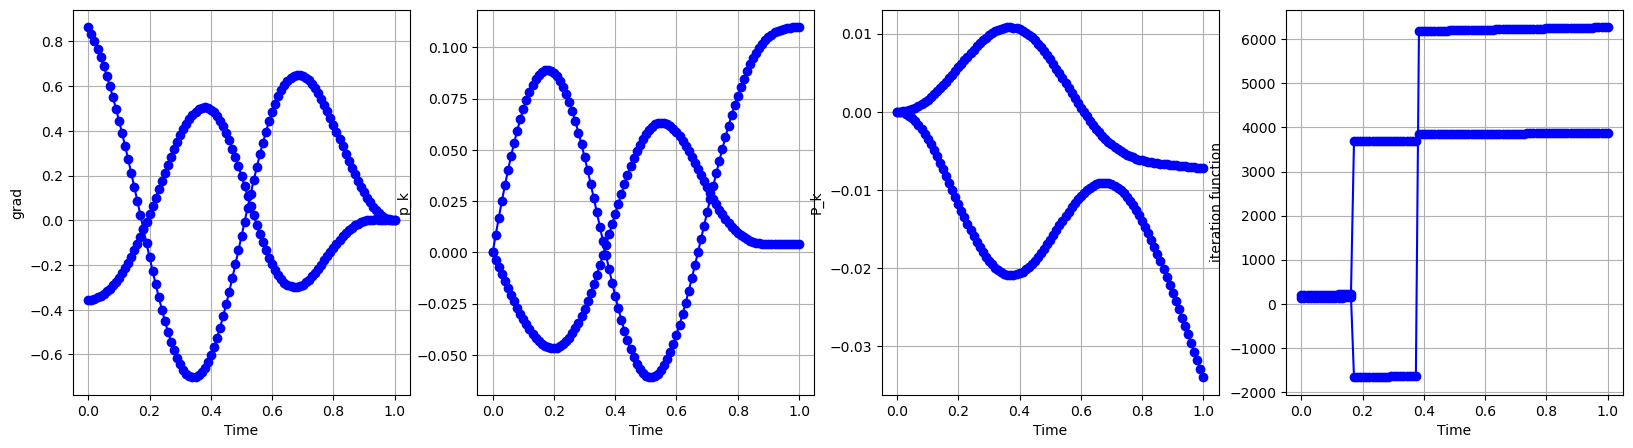

|p_max|/alpha:  1098.2020489733445 , |P_max|/beta:  336.66177395871404
x_S:  0.99 x_K:  0.99 
New point: sigma= [0.99930285 0.03733392] x_0 = 0.99 , type = 0
weights:  [4.01373328e-01 7.82429648e-01 6.31358143e-08] slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
Objective:  462.5587452870168
23 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.4013733276424911 	id: 140534292972704
	 1 sigma= [0.0199031  0.99980191] ,	x_0 = 0.38 ,	type = 0 	weight: 0.7824296482113187 	id: 140534292571888
slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
23 : Hesse condition: 190443479428.04407


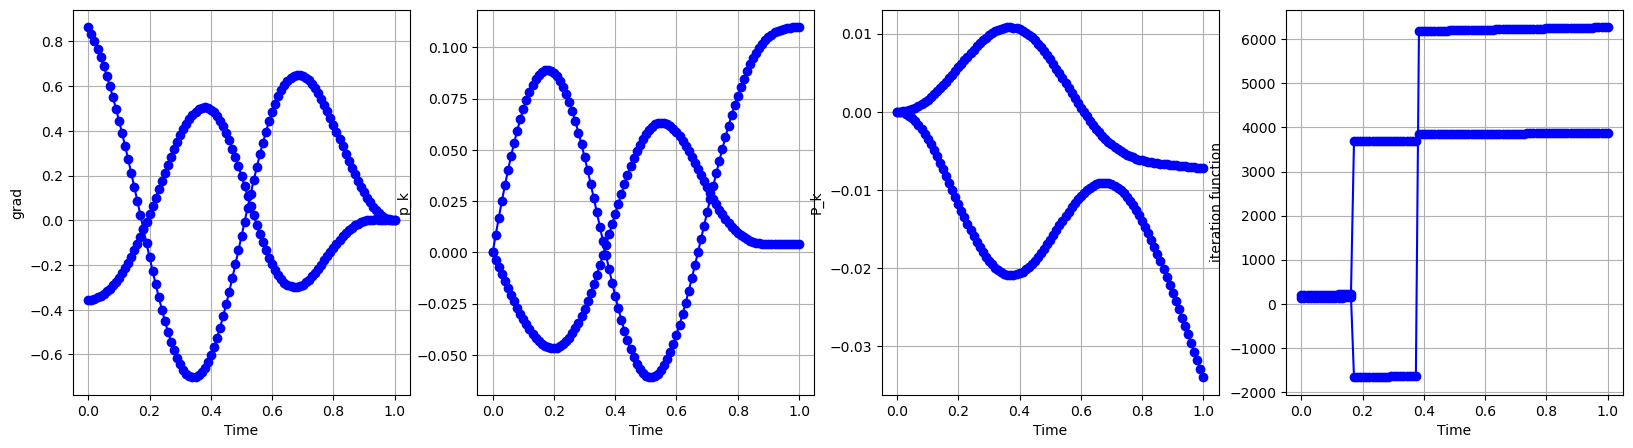

|p_max|/alpha:  1098.2020489733445 , |P_max|/beta:  336.66177395871404
x_S:  0.99 x_K:  0.99 
New point: sigma= [0.99930285 0.03733392] x_0 = 0.99 , type = 0
weights:  [4.01373328e-01 7.82429648e-01 6.31358143e-08] slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
Objective:  462.5587452870168
24 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.4013733276424911 	id: 140534292972704
	 1 sigma= [0.0199031  0.99980191] ,	x_0 = 0.38 ,	type = 0 	weight: 0.7824296482113187 	id: 140534292571888
slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
24 : Hesse condition: 190443479428.04407


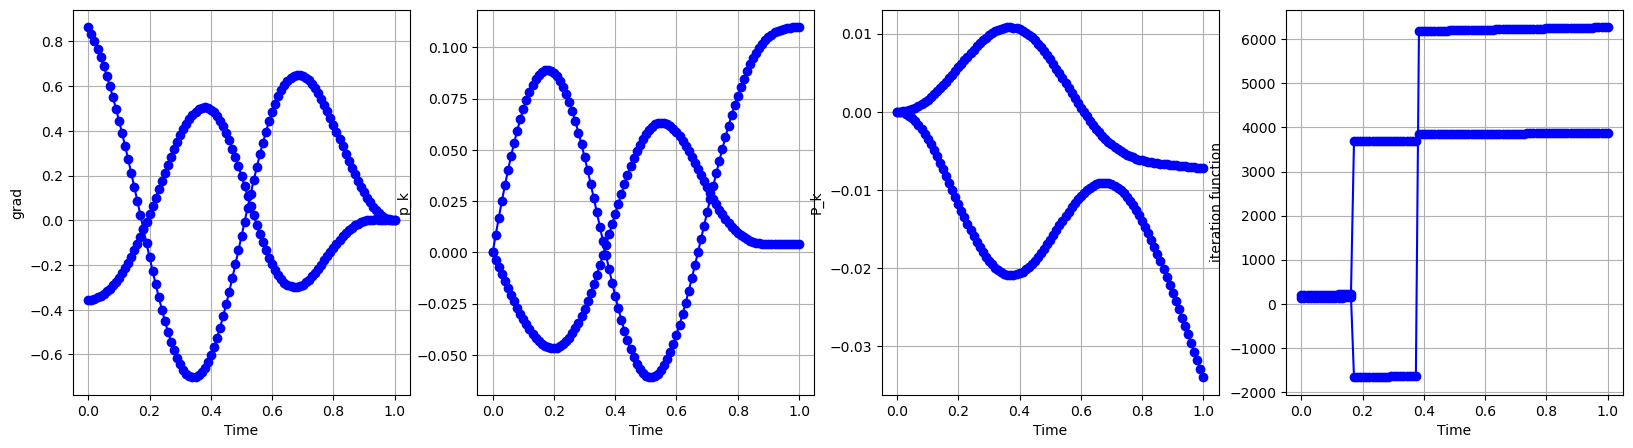

|p_max|/alpha:  1098.2020489733445 , |P_max|/beta:  336.66177395871404
x_S:  0.99 x_K:  0.99 
New point: sigma= [0.99930285 0.03733392] x_0 = 0.99 , type = 0
weights:  [4.01373328e-01 7.82429648e-01 6.31358143e-08] slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
Objective:  462.5587452870168
25 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.4013733276424911 	id: 140534292972704
	 1 sigma= [0.0199031  0.99980191] ,	x_0 = 0.38 ,	type = 0 	weight: 0.7824296482113187 	id: 140534292571888
slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
25 : Hesse condition: 190443479428.04407


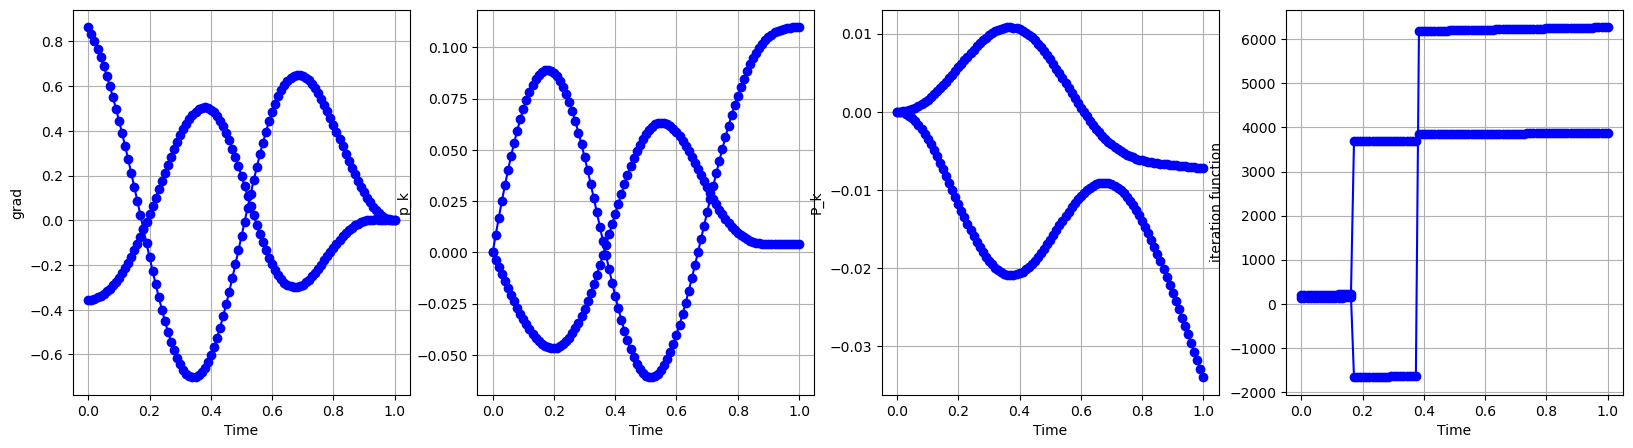

|p_max|/alpha:  1098.2020489733445 , |P_max|/beta:  336.66177395871404
x_S:  0.99 x_K:  0.99 
New point: sigma= [0.99930285 0.03733392] x_0 = 0.99 , type = 0
weights:  [4.01373328e-01 7.82429648e-01 6.31358143e-08] slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
Objective:  462.5587452870168
26 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.4013733276424911 	id: 140534292972704
	 1 sigma= [0.0199031  0.99980191] ,	x_0 = 0.38 ,	type = 0 	weight: 0.7824296482113187 	id: 140534292571888
slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
26 : Hesse condition: 190443479428.04407


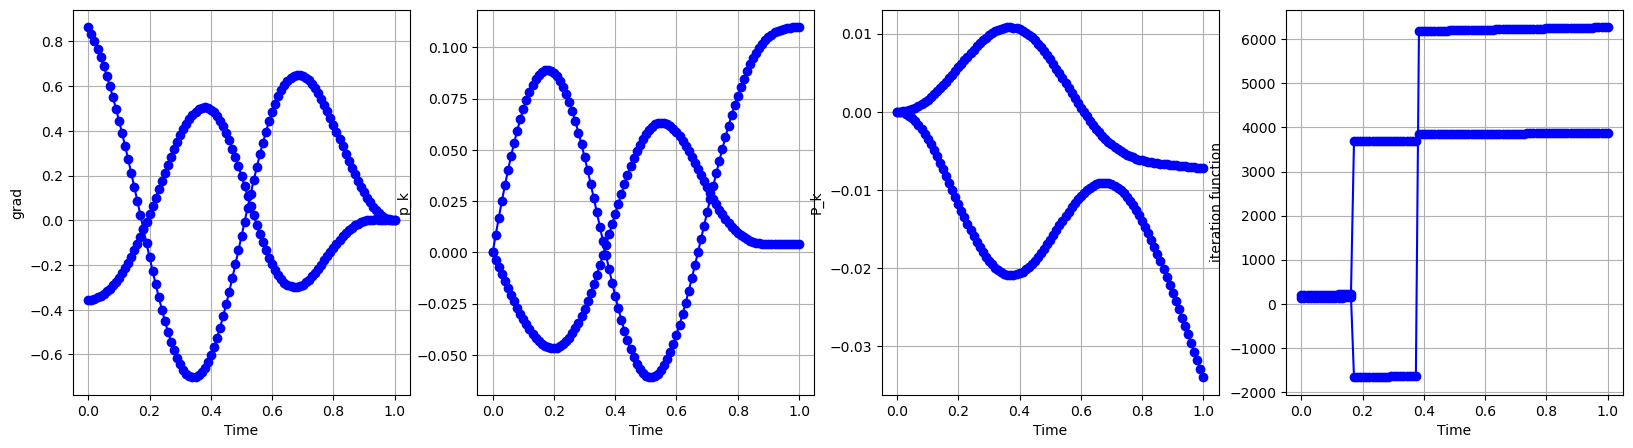

|p_max|/alpha:  1098.2020489733445 , |P_max|/beta:  336.66177395871404
x_S:  0.99 x_K:  0.99 
New point: sigma= [0.99930285 0.03733392] x_0 = 0.99 , type = 0
weights:  [4.01373328e-01 7.82429648e-01 6.31358143e-08] slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
Objective:  462.5587452870168
27 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.4013733276424911 	id: 140534292972704
	 1 sigma= [0.0199031  0.99980191] ,	x_0 = 0.38 ,	type = 0 	weight: 0.7824296482113187 	id: 140534292571888
slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
27 : Hesse condition: 190443479428.04407


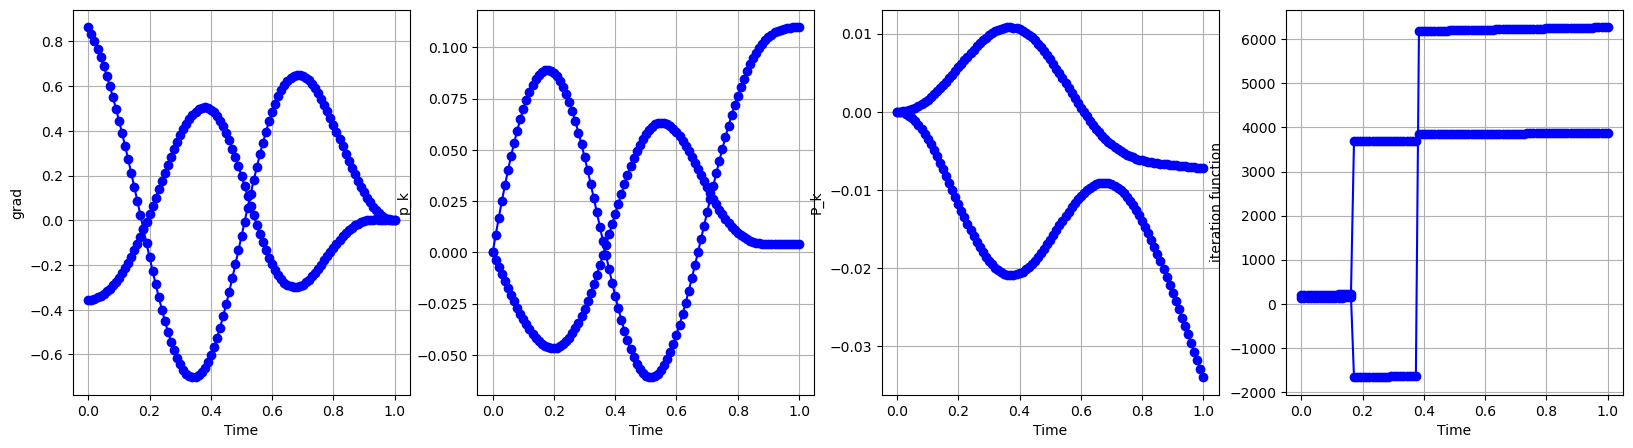

|p_max|/alpha:  1098.2020489733445 , |P_max|/beta:  336.66177395871404
x_S:  0.99 x_K:  0.99 
New point: sigma= [0.99930285 0.03733392] x_0 = 0.99 , type = 0
weights:  [4.01373328e-01 7.82429648e-01 6.31358143e-08] slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
Objective:  462.5587452870168
28 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.4013733276424911 	id: 140534292972704
	 1 sigma= [0.0199031  0.99980191] ,	x_0 = 0.38 ,	type = 0 	weight: 0.7824296482113187 	id: 140534292571888
slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
28 : Hesse condition: 190443479428.04407


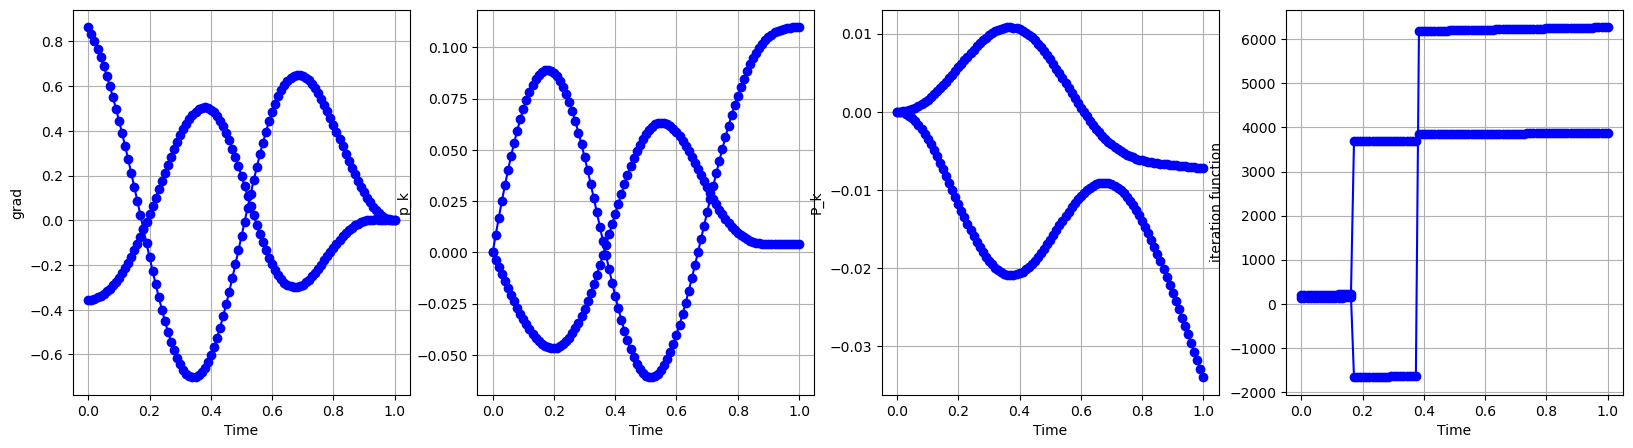

|p_max|/alpha:  1098.2020489733445 , |P_max|/beta:  336.66177395871404
x_S:  0.99 x_K:  0.99 
New point: sigma= [0.99930285 0.03733392] x_0 = 0.99 , type = 0
weights:  [4.01373328e-01 7.82429648e-01 6.31358143e-08] slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
Objective:  462.5587452870168
29 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.4013733276424911 	id: 140534292972704
	 1 sigma= [0.0199031  0.99980191] ,	x_0 = 0.38 ,	type = 0 	weight: 0.7824296482113187 	id: 140534292571888
slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
29 : Hesse condition: 190443479428.04407


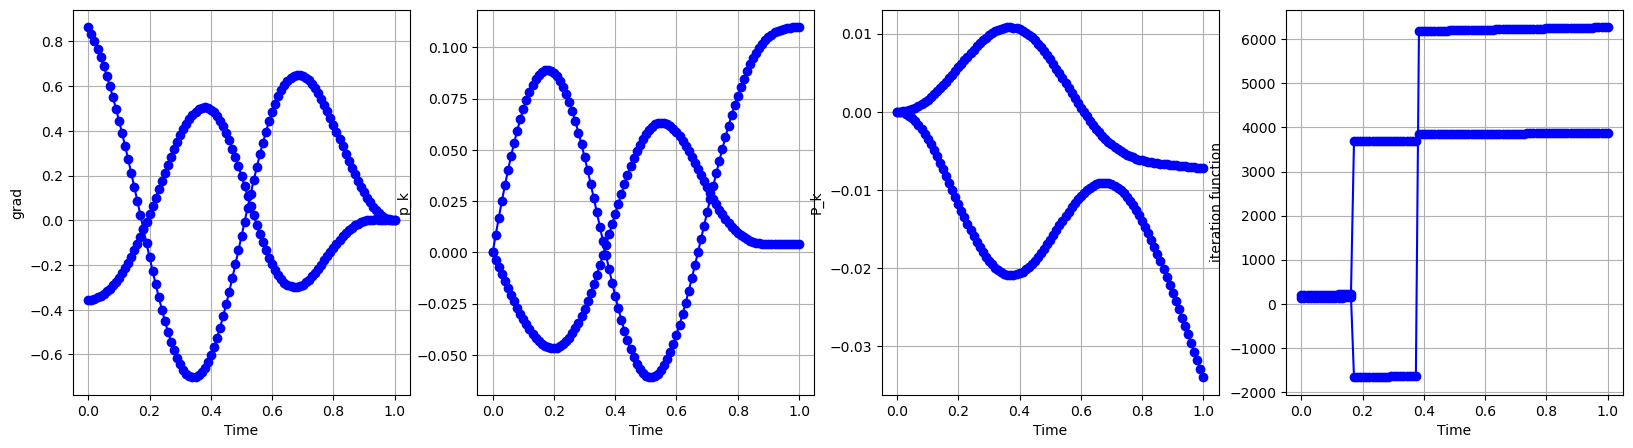

|p_max|/alpha:  1098.2020489733445 , |P_max|/beta:  336.66177395871404
x_S:  0.99 x_K:  0.99 
New point: sigma= [0.99930285 0.03733392] x_0 = 0.99 , type = 0
weights:  [4.01373328e-01 7.82429648e-01 6.31358143e-08] slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
Objective:  462.5587452870168
30 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.4013733276424911 	id: 140534292972704
	 1 sigma= [0.0199031  0.99980191] ,	x_0 = 0.38 ,	type = 0 	weight: 0.7824296482113187 	id: 140534292571888
slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
30 : Hesse condition: 190443479428.04407


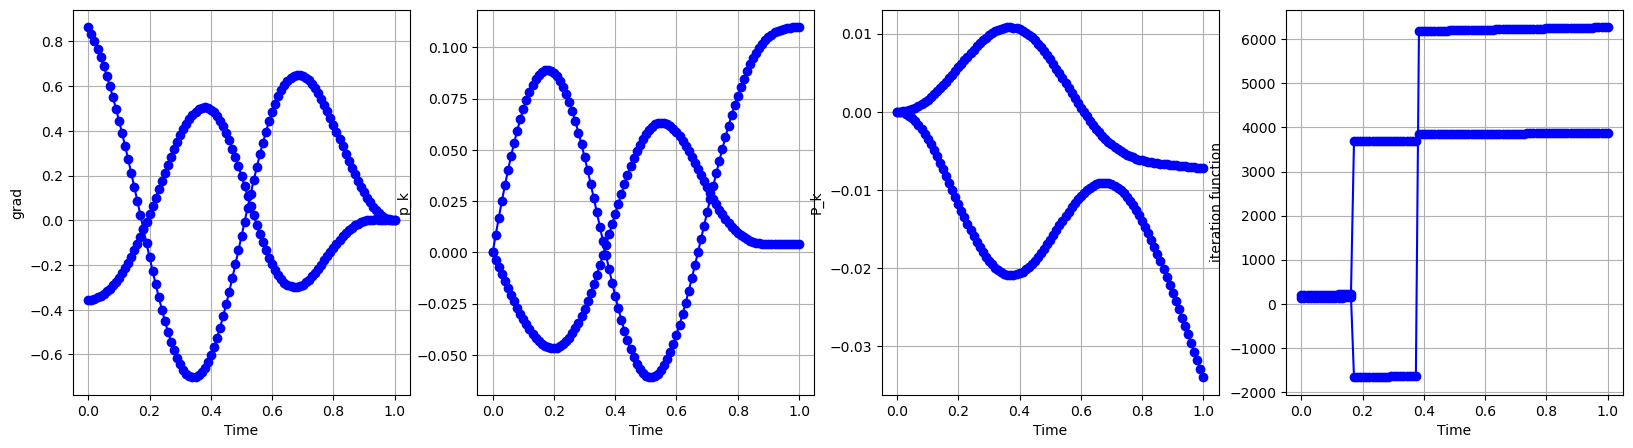

|p_max|/alpha:  1098.2020489733445 , |P_max|/beta:  336.66177395871404
x_S:  0.99 x_K:  0.99 
New point: sigma= [0.99930285 0.03733392] x_0 = 0.99 , type = 0
weights:  [4.01373328e-01 7.82429648e-01 6.31358143e-08] slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
Objective:  462.5587452870168
31 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.4013733276424911 	id: 140534292972704
	 1 sigma= [0.0199031  0.99980191] ,	x_0 = 0.38 ,	type = 0 	weight: 0.7824296482113187 	id: 140534292571888
slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
31 : Hesse condition: 190443479428.04407


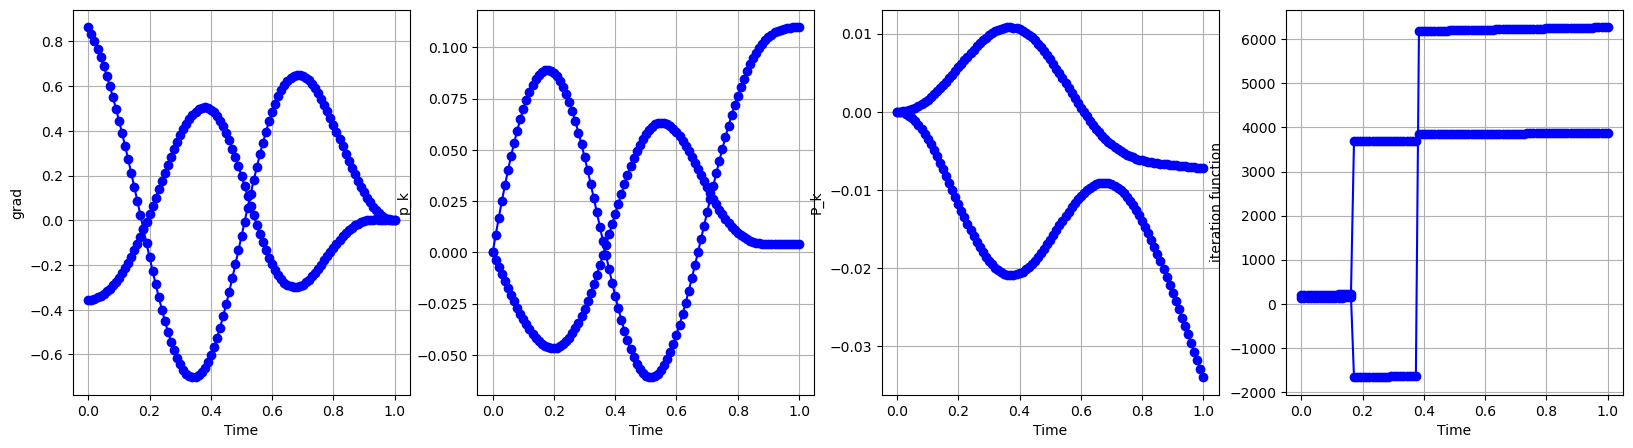

|p_max|/alpha:  1098.2020489733445 , |P_max|/beta:  336.66177395871404
x_S:  0.99 x_K:  0.99 
New point: sigma= [0.99930285 0.03733392] x_0 = 0.99 , type = 0
weights:  [4.01373328e-01 7.82429648e-01 6.31358143e-08] slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
Objective:  462.5587452870168
32 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.4013733276424911 	id: 140534292972704
	 1 sigma= [0.0199031  0.99980191] ,	x_0 = 0.38 ,	type = 0 	weight: 0.7824296482113187 	id: 140534292571888
slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
32 : Hesse condition: 190443479428.04407


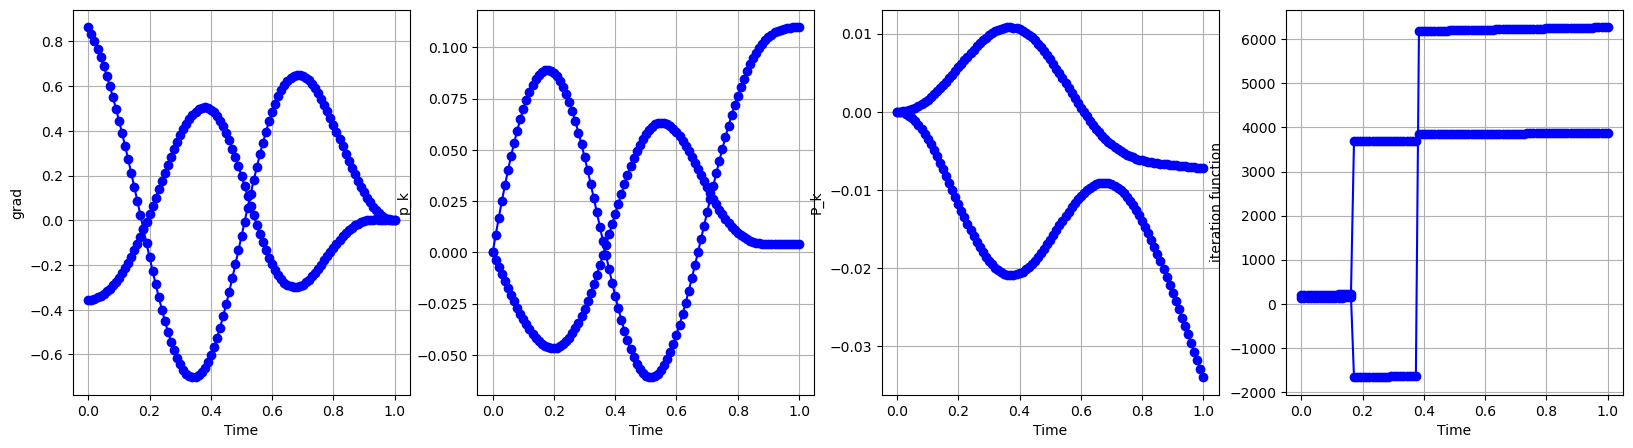

|p_max|/alpha:  1098.2020489733445 , |P_max|/beta:  336.66177395871404
x_S:  0.99 x_K:  0.99 
New point: sigma= [0.99930285 0.03733392] x_0 = 0.99 , type = 0
weights:  [4.01373328e-01 7.82429648e-01 6.31358143e-08] slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
Objective:  462.5587452870168
33 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.4013733276424911 	id: 140534292972704
	 1 sigma= [0.0199031  0.99980191] ,	x_0 = 0.38 ,	type = 0 	weight: 0.7824296482113187 	id: 140534292571888
slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
33 : Hesse condition: 190443479428.04407


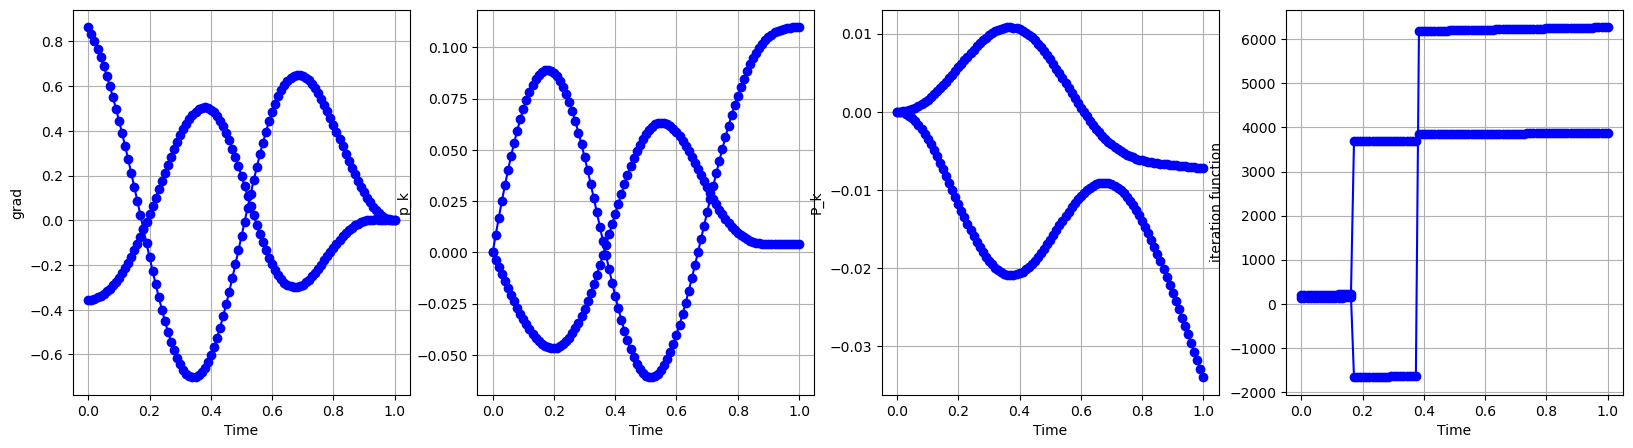

|p_max|/alpha:  1098.2020489733445 , |P_max|/beta:  336.66177395871404
x_S:  0.99 x_K:  0.99 
New point: sigma= [0.99930285 0.03733392] x_0 = 0.99 , type = 0
weights:  [4.01373328e-01 7.82429648e-01 6.31358143e-08] slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
Objective:  462.5587452870168
34 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.4013733276424911 	id: 140534292972704
	 1 sigma= [0.0199031  0.99980191] ,	x_0 = 0.38 ,	type = 0 	weight: 0.7824296482113187 	id: 140534292571888
slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
34 : Hesse condition: 190443479428.04407


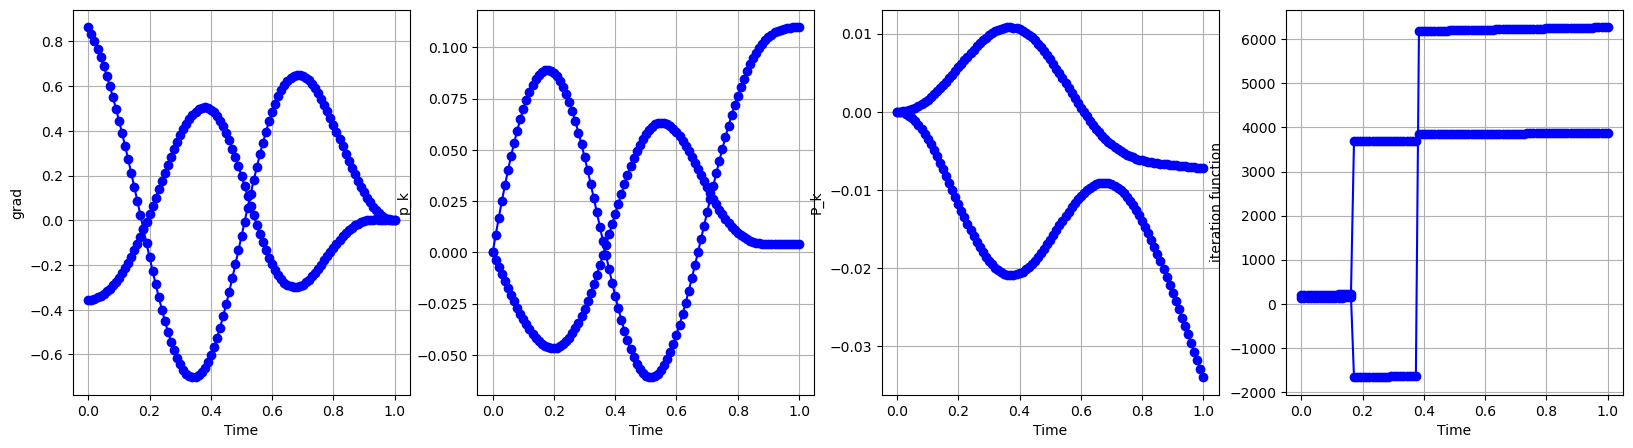

|p_max|/alpha:  1098.2020489733445 , |P_max|/beta:  336.66177395871404
x_S:  0.99 x_K:  0.99 
New point: sigma= [0.99930285 0.03733392] x_0 = 0.99 , type = 0
weights:  [4.01373328e-01 7.82429648e-01 6.31358143e-08] slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
Objective:  462.5587452870168
35 : Active set:
	 0 sigma= [ 0.88294431 -0.46947774] ,	x_0 = 0.17 ,	type = 0 	weight: 0.4013733276424911 	id: 140534292972704
	 1 sigma= [0.0199031  0.99980191] ,	x_0 = 0.38 ,	type = 0 	weight: 0.7824296482113187 	id: 140534292571888
slope:  [ 34.9313535  141.98416539] y_shift [138.22047945 194.17291458]
35 : Hesse condition: 190443479428.04407


In [4]:
active_set = []
hesse = HesseMatrix(active_set, params)
weights = np.ones(len(active_set))
slope = np.ones(params.d)
y_shift = np.ones(params.d)
constraintViolation = np.empty(params.maxIterations)
constraintViolation[:] = np.nan
print('Objective upper bound: ', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesse.standard_states, params))
weights, slope, y_shift = computeOSQPStep(weights, slope, y_shift, active_set, hesse, params)
print('weights: ', weights, 'slope: ', slope, 'y_shift', y_shift)
print('Objective: ', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesse.standard_states, params))
for k in range(params.maxIterations):
    printIterationInfo(k, active_set, weights, slope, y_shift, hesse.matrix)
    u_k = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)
    discreteDf = calculateDiscreteGradient(u_k, params)
    p_k = integrateVectorFunction(discreteDf, params)
    P_k = -integrateVectorFunction(p_k, params)
    
    fig, (ax1, ax2, ax3, ax4) = mpl.pyplot.subplots(1, 4, figsize=(20, 5))
    plot_array(discreteDf, params.T, label='grad', ax=ax1)
    plot_array(p_k, params.T, label='p_k', ax=ax2)
    plot_array(P_k, params.T, label='P_k', ax=ax3)
    plot_array(np.array([u_k(t) for t in discretInterval]), params.T, label='iteration function', ax=ax4)
    mpl.pyplot.show()
    
    idx_S = getIdxMax(p_k, active_set, type=0)
    idx_K = getIdxMax(P_k, active_set, type=1)
    norm_p_max = np.linalg.norm(p_k[idx_S])
    norm_P_max = np.linalg.norm(P_k[idx_K])
    
    print('|p_max|/alpha: ', norm_p_max / params.alpha,  ', |P_max|/beta: ', norm_P_max / params.beta)
    constraintViolation[k] = max(norm_p_max / params.alpha, norm_P_max / params.beta) - 1
    if (max(norm_p_max / params.alpha, norm_P_max / params.beta) <= 1):
        break
    if norm_p_max / params.alpha >= norm_P_max / params.beta:
        active_set.append(ExtremalPoint(p_k[idx_S] / norm_p_max, idx_S * params.dt, type=0, params=params))
    else:
        active_set.append(ExtremalPoint(P_k[idx_K] / norm_P_max, idx_K * params.dt, type=1, params=params))

    print('x_S: ', idx_S * params.dt, 'x_K: ', idx_K * params.dt, '\nNew point: sigma=', active_set[-1].sigma, 'x_0 =', active_set[-1].x_0, ', type =', active_set[-1].type)
    hesse.extendMatrix(active_set[-1])
    weights, slope, y_shift = computeOSQPStep(np.concatenate((weights, np.array([0.]))), slope, y_shift, active_set, hesse, params)
    print('weights: ', weights, 'slope: ', slope, 'y_shift', y_shift)
    active_set, weights = pruneActiveSet(active_set, weights, params.pruneThreshold)
    hesse.pruneMatrix(active_set, weights)
    print('Objective: ', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesse.standard_states, params))

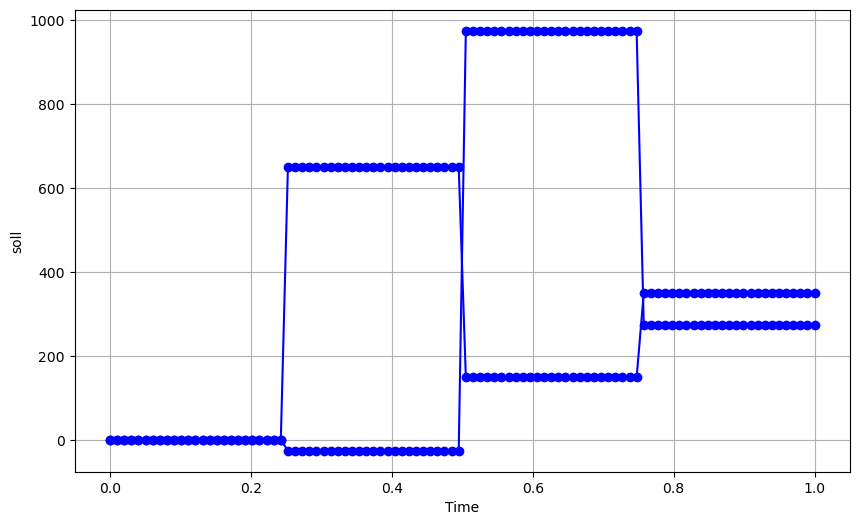

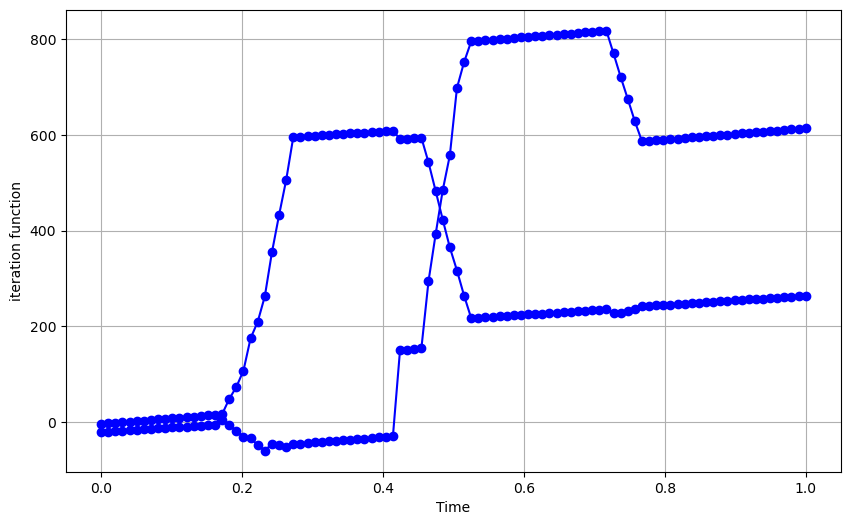

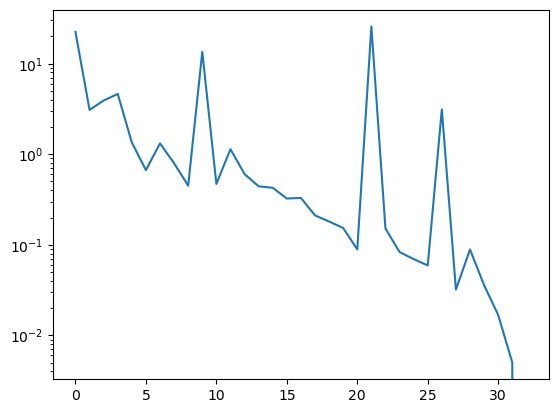

In [ ]:
plot_array(array, params.T, label='soll')
plot_array(np.array([u_k(t) for t in discretInterval]), params.T, label='iteration function')
#plot_array(constraintViolation, params.maxIterations, label='violation')

mpl.pyplot.yscale('log')
mpl.pyplot.plot(constraintViolation)